# Anticipez les besoins en consommations de bâtiments

## Objectif

L'objectif de ce projet est de prédire les émissions de CO2 et la consommation totale d'énergie de bâtiments non destinés à l'habitation de la ville de Seattle à partir de leurs données structurelles (taille, usage, date de construction, localisation) afin d'atteindre l'objectif de neutralité carbone de la ville en 2050.

## 1. Installation du projet et de son environnement

Afin d’utiliser correctement ce notebook, vérifiez que vous disposez du bon environnement pour l’exécuter.


### 1.1 Installation de Python

Pour ce projet, il est nécessaire d’avoir **au minimum Python 3.8**.  
Si ce n’est pas déjà le cas, vous pouvez vous référer à [la documentation officielle](https://www.python.org/downloads/).

Vérifiez votre version de Python :

```bash
python --version
```

### 1.2 Installation de `uv`

`uv` est un gestionnaire de projets Python permettant d’installer et d’organiser les dépendances plus rapidement et plus simplement que les outils traditionnels (`pip`, `virtualenv`, etc.).

Pour installer `uv`, veuillez suivre [la documentation officielle](https://docs.astral.sh/uv/getting-started/installation/#standalone-installer)

Vérifiez l’installation :

```bash
uv --version
```

### 1.3 Création du projet

Créez un nouveau projet Python avec `uv` :

```bash
uv init nom_du_projet
cd nom_du_projet
```

La structure de base du projet est alors générée automatiquement.


### 1.4 Création et activation de l’environnement virtuel

Créez l’environnement virtuel :

```bash
uv venv
```

Activez-le selon votre système :

* **Linux / macOS**

```bash
source .venv/bin/activate
```

* **Windows (PowerShell)**

```powershell
.venv\Scripts\Activate.ps1
```

Voir la documentation officielle :
[https://docs.astral.sh/uv/pip/environments/#creating-a-virtual-environment](https://docs.astral.sh/uv/pip/environments/#creating-a-virtual-environment)



### 1.5 Installation des dépendances

> ❗ Assurez-vous que l’environnement virtuel est **activé** avant d’installer les dépendances.

Installez les bibliothèques nécessaires au projet :

```bash
uv add ipykernel jupyterlab seaborn matplotlib numpy pandas scikit-learn tqdm scipy
```

Ces dépendances sont automatiquement enregistrées dans le fichier `pyproject.toml`.

Vous pouvez visualiser l’ensemble des dépendances installées avec la commande suivante :

```bash
uv tree


## 2. Importation des Bibliothèques


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.axes import Axes
import seaborn as sns
import numpy as np
from scipy import stats
from typing import List, Union
import re

In [2]:
def distribution_column(df: pd.DataFrame, column: str):
    """
    Affiche la distribution de la colonne 'Outlier' dans le DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant la colonne 'Outlier'.
    """
    print(f"📊 Distribution de la colonne {column}")
    print("-" * 100)
    
    outlier_counts = df[column].value_counts(dropna=False)
    outlier_pct = df[column].value_counts(dropna=False, normalize=True) * 100
    
    outlier_summary = pd.DataFrame({
        'Effectif': outlier_counts,
        'Pourcentage': outlier_pct.round(2)
    })
    
    display(outlier_summary)

def display_columns_info(df: pd.DataFrame, columns: List[str]) -> None:
    """Affiche un résumé descriptif et visuel des colonnes sélectionnées d'un DataFrame pandas."""

    if df.empty:
        print("⚠️ DataFrame vide – aucune analyse possible.")
        return

    total_rows = len(df)

    for idx, col in enumerate(columns, 1):

        # Colonne inexistante
        if col not in df.columns:
            print(f"┌─ {idx}. {col}")
            print("│  ❌ Colonne inexistante")
            print("└" + "─" * 78)
            print()
            continue

        series = df[col]

        n_unique = series.nunique(dropna=True)
        n_missing = series.isna().sum()

        pct_unique = n_unique / total_rows * 100
        pct_missing = n_missing / total_rows * 100

        # En-tête colonne
        print(f"┌─ {idx}. {col}")
        print("│")

        # Type de données
        if pd.api.types.is_numeric_dtype(series):
            type_emoji = "🔢"
        elif pd.api.types.is_datetime64_any_dtype(series):
            type_emoji = "📅"
        else:
            type_emoji = "🔤"

        print(f"│  {type_emoji} Type: {series.dtype}")

        # Valeurs uniques
        print(f"│  🎯 Uniques: {n_unique:,} ({pct_unique:.1f}%)")

        # Valeurs manquantes
        if n_missing > 0:
            print(f"│  ⚠️ Manquantes: {n_missing:,} ({pct_missing:.1f}%)")
        else:
            print("│  ✅ Manquantes: 0 (0.0%)")

        # Valeurs explicites si peu nombreuses
        if 0 < n_unique <= 10:
            values = series.dropna().unique()
            values_str = ", ".join(map(str, values))
            if len(values_str) > 60:
                values_str = values_str[:60] + "..."
            print(f"│  📋 Valeurs: {values_str}")

        # Statistiques numériques
        if pd.api.types.is_numeric_dtype(series) and n_unique > 10:
            min_val = series.min()
            max_val = series.max()
            mean_val = series.mean()

            mean_str = f"{mean_val:.2f}" if pd.notna(mean_val) else "N/A"

            print(
                f"│  📈 Min: {min_val:.2f} | Max: {max_val:.2f} | Moyenne: {mean_str}"
            )

        print("└" + "─" * 78)
        print()

def remove_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Supprime les colonnes spécifiées du DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame d'origine.
        columns (list): Liste des noms de colonnes à supprimer.

    Returns:
        pd.DataFrame: Le DataFrame sans les colonnes supprimées.
    """
    print("📦 Suppression de colonnes")
    print(f"   ➤ Shape initiale        : {df.shape}")
    print(f"   ➤ Colonnes demandées    : {len(columns)}")

    # Colonnes réellement présentes
    existing_cols = [col for col in columns if col in df.columns]
    missing_cols = [col for col in columns if col not in df.columns]

    df = df.drop(columns=existing_cols)

    print(f"✅ Suppression terminée")
    print(f"   ➤ Shape finale          : {df.shape}")
    print(f"   ➤ Colonnes supprimées   : {len(existing_cols)}")

    if existing_cols:
        print(f"   🧹 Liste supprimée       : {existing_cols}")

    if missing_cols:
        print(f"   ⚠️ Colonnes inexistantes : {missing_cols}")

    return df

def compare_describe_statistics(
    df_ref,
    df_comp,
    columns,
    stats=('mean', '50%', 'std'),
    stat_labels=('Moyenne', 'Médiane', 'Écart-type'),
    ref_label='Avec outliers',
    comp_label='Sans outliers',
    n_cols=2,
    figsize=(16, 12),
    title="Comparaison des statistiques descriptives",
    summary_columns=None,
    mean_alert_thresholds=(5, 10)
):
    """
    Compare les statistiques issues de df.describe() entre deux dataframes.

    Parameters
    ----------
    df_ref : pd.DataFrame
        DataFrame de référence (ex : avec outliers)

    df_comp : pd.DataFrame
        DataFrame comparé (ex : sans outliers)

    columns : list
        Colonnes numériques à comparer

    stats : tuple
        Statistiques issues de describe() à comparer

    stat_labels : tuple
        Labels affichés pour les statistiques

    ref_label / comp_label : str
        Libellés affichés dans les graphiques

    n_cols : int
        Nombre de colonnes dans la grille matplotlib

    figsize : tuple
        Taille de la figure

    title : str
        Titre global

    summary_columns : list or None
        Colonnes incluses dans le résumé textuel

    mean_alert_thresholds : tuple
        Seuils (%) pour interpréter l'impact sur la moyenne
    """

    desc_ref = df_ref[columns].describe()
    desc_comp = df_comp[columns].describe()

    n_rows = int(np.ceil(len(columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.995)

    for idx, col in enumerate(columns):
        ax = axes[idx]

        ref_values = [desc_ref.loc[s, col] for s in stats]
        comp_values = [desc_comp.loc[s, col] for s in stats]

        variations = [
            ((comp - ref) / ref * 100) if ref != 0 else np.nan
            for ref, comp in zip(ref_values, comp_values)
        ]

        x = np.arange(len(stats))
        width = 0.35

        ax.bar(
            x - width / 2,
            ref_values,
            width,
            label=ref_label,
            color='#e74c3c',
            alpha=0.8
        )

        bars_comp = ax.bar(
            x + width / 2,
            comp_values,
            width,
            label=comp_label,
            color='#2ecc71',
            alpha=0.8
        )

        ax.set_title(col, fontweight='bold')
        ax.set_ylabel('Valeur')
        ax.set_xticks(x)
        ax.set_xticklabels(stat_labels)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        # Annotation variation %
        for bar, delta in zip(bars_comp, variations):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{delta:+.1f}%",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold',
                color='green' if delta < 0 else 'red'
            )

    # Supprimer axes inutilisés
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    # ======================
    # Résumé textuel
    # ======================
    if summary_columns is None:
        summary_columns = columns

    print("\n" + "=" * 80)
    print("RÉSUMÉ DE LA COMPARAISON DES STATISTIQUES")
    print("=" * 80)

    mod_threshold, high_threshold = mean_alert_thresholds

    for col in summary_columns:
        ref_mean = desc_ref.loc['mean', col]
        comp_mean = desc_comp.loc['mean', col]
        delta_mean = ((comp_mean - ref_mean) / ref_mean * 100) if ref_mean != 0 else np.nan

        print(f"\n{col} :")
        for s, label in zip(stats, stat_labels):
            ref_val = desc_ref.loc[s, col]
            comp_val = desc_comp.loc[s, col]
            delta = ((comp_val - ref_val) / ref_val * 100) if ref_val != 0 else np.nan

            print(f"   • {label} : {delta:+.2f}%")

        if abs(delta_mean) > high_threshold:
            print(f"   ⚠️ Impact FORT sur la moyenne (>{high_threshold}%)")
        elif abs(delta_mean) > mod_threshold:
            print(f"   ⚡ Impact MODÉRÉ sur la moyenne")
        else:
            print(f"   ✅ Impact FAIBLE sur la moyenne")

## 3. Chargement du jeu de donnée

- **Jeu de données** : [2016_Building_Energy_Benchmarking.csv](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv)
- **Source officielle** : [Building Energy Benchmarking - Seattle Open Data](https://data.seattle.gov/Built-Environment/Building-Energy-Benchmarking-Data-2015-Present/teqw-tu6e/about_data)

> 📁 **Action** : Téléchargez le jeu de données et ajoutez-le dans le dossier `data/`

In [3]:
# Configuration de l'affichage pandas
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
pd.set_option('display.width', None)         # Largeur automatique

df_origin = pd.read_csv('data/2016_Building_Energy_Benchmarking.csv')

df = df_origin.copy()

## 5. Information générale du Dataset

In [4]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [5]:
display(df.shape)

(3376, 46)

**Dimensions du dataset :**
- 3376 lignes (bâtiments)
- 46 colonnes

In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

None

#### Synthèse de la structure des données

**Types de données :**
- 8 colonnes numériques entières (`int64`)
- 22 colonnes numériques décimales (`float64`)
- 15 colonnes textuelles (`object`)
- 1 colonne booléenne (`bool`)

**Colonnes à analyser pouvant contenir des lignes problématiques :**
- `Outlier` : indique si un bâtiment est considéré comme un outlier
- `ComplianceStatus` : indique si un bâtiment a satisfait aux exigences réglementaires de déclaration énergétique

**Valeurs manquantes importantes :**
- `Comments` : 0 valeur renseignée (colonne complètement vide)
- `YearsENERGYSTARCertified` : 119 / 3376 (3,5 %)
- `Outlier` : 32 / 3376 (0,9 %)
- `ThirdLargestPropertyUseType(GFA)` : 596 / 3376 (17,7 %)
- `SecondLargestPropertyUseType(GFA)` : 1679 / 3376 (49,7 %)
- `ENERGYSTARScore` : 2533 / 3376 (75,0 %)

**Variables cibles : couverture excellente**
- `TotalGHGEmissions` : 3367 / 3376 (99,7 %)
- `SiteEnergyUse(kBtu)` : 3371 / 3376 (99,9 %)

**Points d'attention :**
- `ZipCode` : stocké en `float64` au lieu de `string` (16 valeurs manquantes)



In [7]:
df.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


### Synthèse des statistiques descriptives

**Colonnes analysées :** 22 colonnes numériques (sur 46 au total)

**Observations principales :**

1. **Caractéristiques des bâtiments :**
   - Année de construction : entre 1900 et 2015 (médiane : 1975)
   - Nombre d'étages : 0 à 99 (médiane : 4 étages)
   - Surface totale (PropertyGFATotal) : très variable de 11,285 à 9,320,156 sq ft

2. **Valeurs aberrantes détectées :**
   - `Electricity(kWh)` : valeur minimale négative (-33,827)
   - `Electricity(kBtu)` : valeur minimale négative (-115,417)
   - `TotalGHGEmissions` : valeur minimale négative (-0.8)
   - `GHGEmissionsIntensity` : valeur minimale négative (-0.02)
   - `SourceEUIWN(kBtu/sf)` : valeur minimale négative (-2.1)

3. **Distribution des variables cibles :**
   - **TotalGHGEmissions :** moyenne = 119.7, médiane = 33.9 (distribution asymétrique)
   - **SiteEnergyUse(kBtu) :** moyenne = 5.4M, médiane = 1.8M (forte variabilité)

4. **Forte variabilité :**
   - Les écarts-types sont très élevés pour la plupart des variables énergétiques
   - Présence probable de valeurs extrêmes (outliers)
   - Exemple : SteamUse varie de 0 à 134M kBtu

5. **Score ENERGYSTAR :**
   - Moyenne : 67.9/100 (sur 2533 bâtiments notés)
   - 75% des bâtiments notés ont un score ≥ 53

In [8]:
def analyze_missing_values(df: pd.DataFrame, display_table: bool = True) -> pd.DataFrame:
    """
    Analyse les valeurs manquantes dans un DataFrame.
    
    Args:
        df (pd.DataFrame): Le DataFrame à analyser.
        display_table (bool): Si True, affiche le tableau détaillé des valeurs manquantes.
    
    Returns:
        pd.DataFrame: DataFrame avec les statistiques de valeurs manquantes par colonne.
    """
    # 1. Pourcentage global de cellules vides
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isna().sum().sum()
    pct_missing_global = (missing_cells / total_cells) * 100
    
    print(f"\n🌐 Pourcentage de cellules vides sur tout le DataFrame : {pct_missing_global:.2f}%")
    
    # 2. Pourcentage par colonne
    missing_by_column = df.isna().sum()
    pct_by_column = (missing_by_column / len(df)) * 100
    
    # Créer un DataFrame pour les statistiques
    missing_df = pd.DataFrame({
        'Colonne': df.columns,
        'Valeurs manquantes': missing_by_column.values,
        'Pourcentage (%)': pct_by_column.values
    })
    
    # Trier par pourcentage décroissant
    missing_df = missing_df.sort_values('Pourcentage (%)', ascending=False)
    
    # Afficher le tableau si demandé
    # if display_table:
    #     print(f"\n📋 Pourcentage de cellules vides par colonne :")
    #     print("-" * 80)
    #     display(missing_df[missing_df['Pourcentage (%)'] > 0])

    return missing_df

def display_missing_values(df: pd.DataFrame):
    """
    Analyse les valeurs manquantes dans un DataFrame.
    
    Args:
        df (pd.DataFrame): Le DataFrame à analyser.
        display_table (bool): Si True, affiche le tableau détaillé des valeurs manquantes.
    
    Returns:
        pd.DataFrame: DataFrame avec les statistiques de valeurs manquantes par colonne.
    """
    print(f"\n📋 Pourcentage de cellules vides par colonne :")
    print("-" * 80)
    missing_stats = analyze_missing_values(df, True)
    display(missing_stats[missing_stats['Pourcentage (%)'] > 0])


def plot_missing_values(missing_df: pd.DataFrame, top_n: int = 15, min_threshold: float = 0.1):
    """
    Visualise les valeurs manquantes sous forme de graphique à barres horizontales.
    
    Args:
        missing_df (pd.DataFrame): DataFrame retourné par analyze_missing_values().
        top_n (int): Nombre maximum de colonnes à afficher (par défaut: 15).
        min_threshold (float): Pourcentage minimum pour afficher une colonne (par défaut: 0.1%).
    """
    # Filtrer les colonnes selon le seuil
    missing_cols = missing_df[missing_df['Pourcentage (%)'] >= min_threshold].head(top_n).copy()
    
    if len(missing_cols) > 0:
        fig, ax = plt.subplots(figsize=(14, max(6, len(missing_cols) * 0.4)))
        
        # Créer le graphique horizontal
        bars = ax.barh(range(len(missing_cols)), missing_cols['Pourcentage (%)'])
        ax.set_yticks(range(len(missing_cols)))
        ax.set_yticklabels(missing_cols['Colonne'], fontsize=10)
        ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12, fontweight='bold')
        ax.set_title('Principales colonnes avec valeurs manquantes', fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Colorer les barres selon le niveau de gravité
        colors = ['#2ecc71' if x < 1 else '#f39c12' if x < 5 else '#e74c3c' 
                  for x in missing_cols['Pourcentage (%)']]
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        # Ajouter les valeurs sur les barres
        for i, (idx, row) in enumerate(missing_cols.iterrows()):
            ax.text(row['Pourcentage (%)'] + 0.5, i, f"{row['Pourcentage (%)']:.2f}%", 
                    va='center', fontsize=9, fontweight='bold')
        
        legend_elements = [
            Patch(facecolor='#2ecc71', label='< 1% manquant (excellente couverture)'),
            Patch(facecolor='#f39c12', label='1-5% manquant (bonne couverture)'),
            Patch(facecolor='#e74c3c', label='> 5% manquant (attention requise)')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
        
        # Ajuster les marges pour éviter les warnings
        plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.1)
        plt.show()
    else:
        print(f"✅ Aucune colonne avec ≥ {min_threshold}% de valeurs manquantes !")



🌐 Pourcentage de cellules vides sur tout le DataFrame : 12.85%


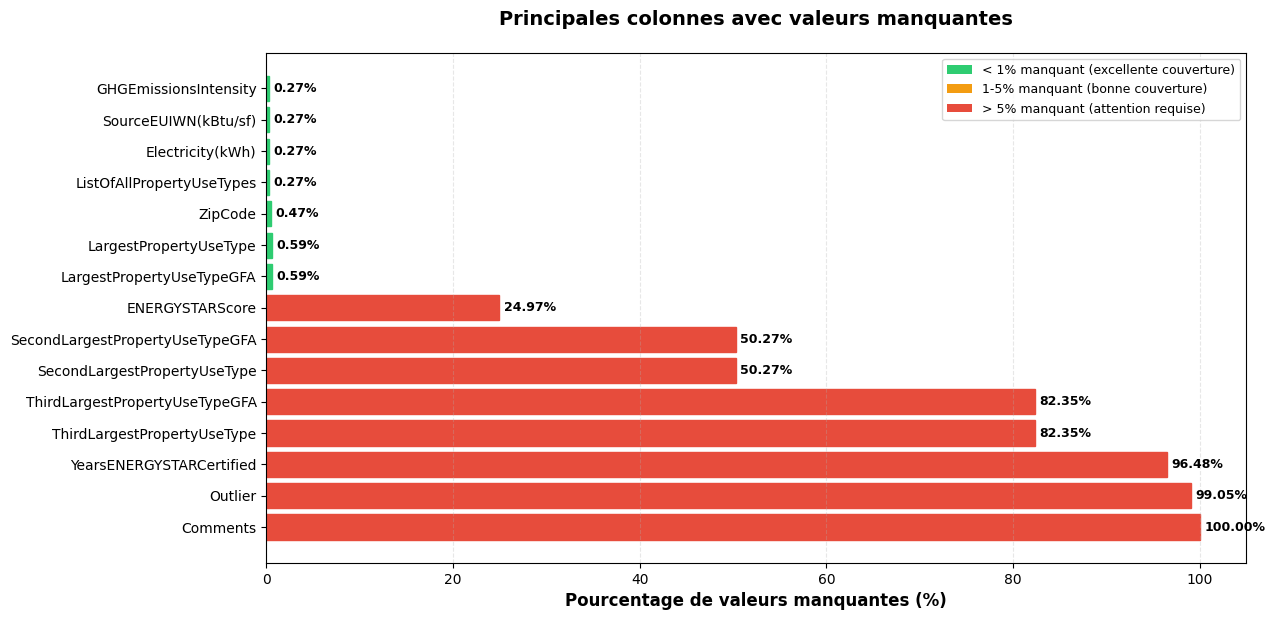

In [9]:
missing_stats = analyze_missing_values(df, True)
plot_missing_values(missing_stats, top_n=15, min_threshold=0.1)

## 4. Choix des variables cibles

Pour répondre à l'objectif, je dois choisir 2 variables cibles. L'une pour prédire les émissions de CO2 et l'autre pour la consommation totale d'énergie.

### 1. Cibles liées aux émissions de CO₂

| Colonne | Description |
|--------------------|---------------------------|
| **TotalGHGEmissions** | Quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et l'oxyde nitreux, rejetées dans l'atmosphère à la suite de la consommation d'énergie dans l'immeuble, mesurée en tonnes métriques d'équivalent dioxyde de carbone. |
| **GHGEmissionsIntensity** | Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. |


### 2. Cibles liées à la consommation d’énergie


| Colonne | Description |
|--------------------|---------------------------|
| **SiteEUI(kBtu/sf)** | L'intensité énergétique du site (EUI) correspond à la consommation énergétique du site divisée par sa surface brute. La consommation énergétique du site correspond à la quantité annuelle totale d'énergie consommée par le site, telle qu'indiquée sur les factures d'électricité. L'EUI du site est mesurée en milliers de British thermal units (kBtu) par pied carré. |
| **SiteEUIWN(kBtu/sf)** | *SiteEUI(kBtu/sf)*, normalisée aux conditions météorologiques moyennes sur 30 ans |
| **SourceEUI(kBtu/sf)** | L'intensité énergétique à la source (EUI) correspond à la consommation d'énergie à la source d'un bien immobilier divisée par sa surface brute. La consommation d'énergie à la source correspond à l'énergie annuelle utilisée pour faire fonctionner le bien immobilier, y compris les pertes liées à la production, au transport et à la distribution. L'EUI à la source est mesurée en milliers de British thermal units (kBtu) par pied carré. |
| **SourceEUIWN(kBtu/sf)** | *SourceEUI(kBtu/sf)*, normalisée aux conditions météorologiques moyennes sur 30 ans |
| **SiteEnergyUse(kBtu)** | La quantité annuelle d'énergie consommée par la propriété, toutes sources d'énergie confondues |
| **SiteEnergyUseWN(kBtu)** | *SiteEnergyUse(kBtu)*, normalisée aux conditions météorologiques moyennes sur 30 ans |


## Choix final des cibles

Après analyse, les cibles retenues sont :

### 🎯 Cible CO₂
- **GHGEmissionsIntensity**
- Permet une comparaison équitable entre bâtiments
- Alignée avec les politiques climatiques

### ⚡ Cible énergie
- **SiteEUI(kBtu/sf)**
- Indicateur de référence de l’efficacité énergétique
- Moins dépendant de la taille du bâtiment

In [10]:
TARGET_CO2 = 'GHGEmissionsIntensity'
TARGET_ENERGY = 'SiteEUI(kBtu/sf)'
CIBLES = [TARGET_ENERGY, TARGET_CO2]

## 6. Filtrage des bâtiments non résidentiels

Pour le projet, nous avons uniquement besoin des bâtiments non résidentiels. Pour cela, nous allons commencer par filtrer le jeu de données.

In [11]:
df["BuildingType"].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

**Observations :**

- **NonResidential (1 460)** : Bâtiments non résidentiels  
- **Multifamily LR (1–4) (1 018)** : Immeubles multifamiliaux à faible densité  
- **Multifamily MR (5–9) (580)** : Immeubles multifamiliaux à densité moyenne  
- **Multifamily HR (10+) (110)** : Immeubles multifamiliaux à haute densité  
- **SPS-District K–12 (98)** : Établissements scolaires publics (de la maternelle au lycée)  
- **Nonresidential COS (85)** : Bâtiments municipaux de la ville de Seattle  
- **Campus (24)** : Ensembles de bâtiments interconnectés  
- **Nonresidential WA (1)** : Bâtiment appartenant à l’État de Washington  

Dans le cadre du projet, seuls les bâtiments **non destinés à l’habitation** sont requis. Par conséquent, nous conserverons uniquement les catégories suivantes :

- **NonResidential (1 460)** : Bâtiments non résidentiels  
- **SPS-District K–12 (98)** : Établissements scolaires publics  
- **Nonresidential COS (85)** : Bâtiments municipaux de Seattle  
- **Campus (24)** : Ensembles de bâtiments interconnectés
- **Nonresidential WA (1)**: Bâtiment de l’État de Washington

Pour le bâtiment de l’État de Washington, nous modifions son type afin de le rattacher à la catégorie `NonResidential`, ce qui permet d’éviter la présence d’une catégorie ne contenant qu’un seul élément dans le cadre de la modélisation.


In [12]:
print(f"Nombre de lignes avant filtrage par type de batiment : {len(df)}")

df.loc[
    df["BuildingType"] == "Nonresidential WA",
    "BuildingType"
] = "Nonresidential COS"

# Types de bâtiments à conserver
building_types_to_keep = [
    "NonResidential",
    "SPS-District K-12",
    "Nonresidential COS",
    "Campus",
    "Nonresidential WA"
]

# Filtrer les données
df = df[df['BuildingType'].isin(building_types_to_keep)]

# Documenter le nombre de lignes après filtrage
print(f"Nombre de lignes après filtrage : {len(df)}")
print(f"Nombre de lignes supprimées : {len(df_origin) - len(df)}")
# Afficher la répartition des types de bâtiments conservés
print("\nRépartition des types de bâtiments conservés :")
print(df['BuildingType'].value_counts())

Nombre de lignes avant filtrage par type de batiment : 3376
Nombre de lignes après filtrage : 1668
Nombre de lignes supprimées : 1708

Répartition des types de bâtiments conservés :
BuildingType
NonResidential        1460
SPS-District K-12       98
Nonresidential COS      86
Campus                  24
Name: count, dtype: int64


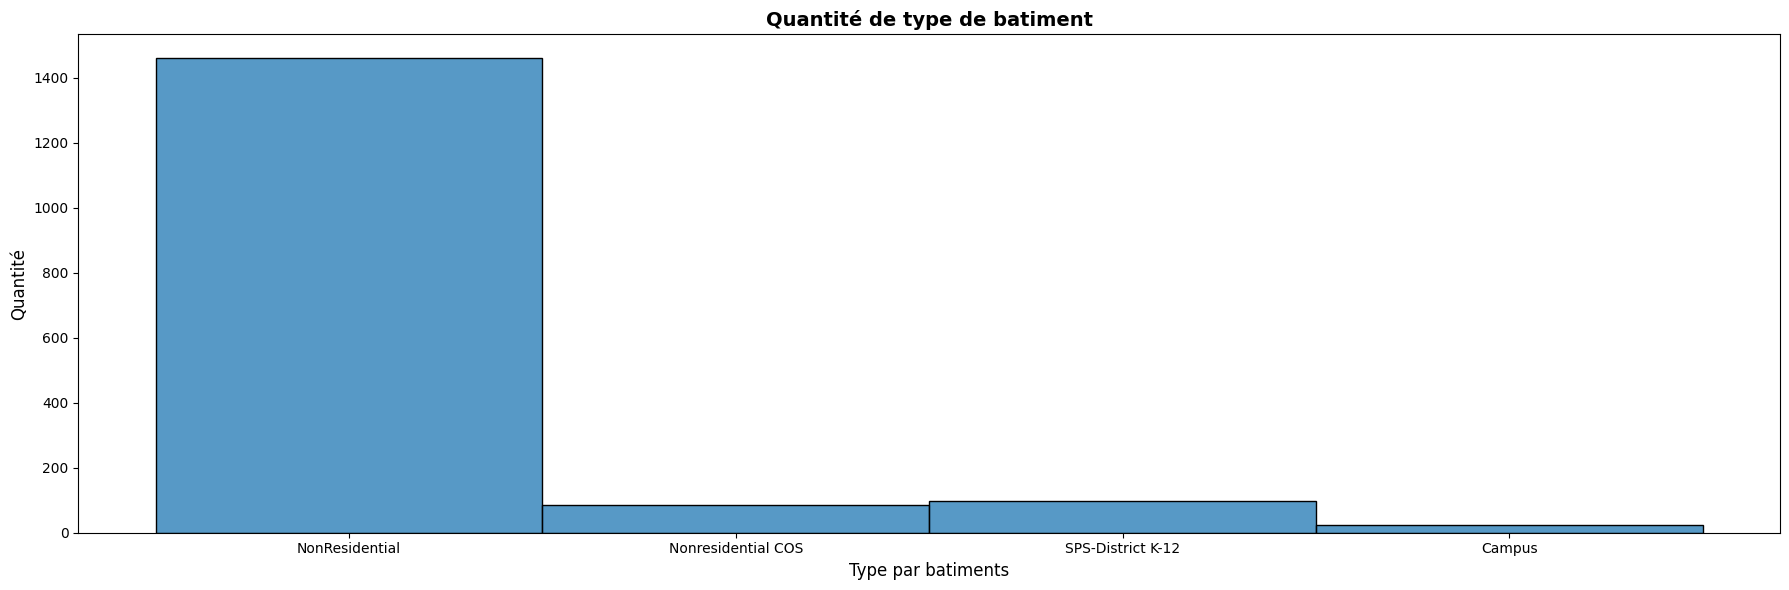

In [13]:
def create_hist(
    df: pd.DataFrame,
    ax: plt.Axes,
    x_col: str,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    rotate_x: int = 0
):
    sns.histplot(
        data=df,
        x=x_col,
        # bins=20, 
        # kde=True
    )

    if rotate_x:
        ax.tick_params(axis='x', rotation=rotate_x)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

fig, axes = plt.subplots(1, 1, figsize=(18, 6))
create_hist(
    df,
    axes,
    "BuildingType",
    "Quantité de type de batiment",
    "Type par batiments",
    "Quantité"
)
plt.tight_layout()
plt.show()


## 7. Vérification des doublons

La vérification des doublons est essentielle pour garantir la qualité des données avant toute analyse ou modélisation. Des doublons peuvent fausser les statistiques, introduire des biais dans les modèles prédictifs et conduire à des conclusions erronées.

### Stratégie de détection

Je vais vérifier les doublons selon plusieurs niveaux de granularité :

1. **Doublons complets** : Lignes identiques sur toutes les colonnes (très rare)
2. **Doublons sur l'identifiant** : `OSEBuildingID` (doit être unique par définition)
3. **Doublons géographiques** : Combinaison `Address + City + ZipCode`

### Pourquoi plusieurs vérifications ?

- Un même bâtiment pourrait avoir des données légèrement différentes (erreurs de saisie, mises à jour)
- Plusieurs bâtiments pourraient partager une même adresse (complexes immobiliers)

In [14]:
def verify_duplicates(
    df: pd.DataFrame,
    columns: Union[List[str], None] = None,
    display_table: bool = False,
    preview_rows: int = 10
) -> int:
    """
    Vérifie les doublons dans un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame à analyser
        columns (list[str] | None): Colonnes à utiliser pour la détection.
        display_table (bool): Si True, affiche les lignes dupliquées
        preview_rows (int): Nombre de lignes dupliquées à afficher

    Returns:
        int: Nombre de doublons détectés
    """
    if df.empty:
        print("⚠️ Le DataFrame est vide.")
        return 0

    subset = None
    if columns:
        missing_cols = set(columns) - set(df.columns)
        if missing_cols:
            raise ValueError(f"Colonnes inexistantes : {missing_cols}")
        subset = columns
        label = f"Doublons sur {columns}"
    else:
        label = "Toutes les colonnes"

    duplicates = df.duplicated(subset=subset).sum()
    percentage = (duplicates / len(df)) * 100

    print(f"\n Colonnes concernés : {label} ")
    print(f"\n🔍 Nombre de doublons : {duplicates}")
    print(f"📊 Pourcentage : {percentage:.2f}%")

    if duplicates > 0 and display_table:
        print("\n🔍 Aperçu des lignes dupliquées :")
        print("-" * 80)

        sort_cols = subset if subset else df.columns.tolist()
        duplicated_rows = (
            df[df.duplicated(subset=subset, keep=False)]
            .sort_values(by=sort_cols)
        )

        try:
            display(duplicated_rows.head(preview_rows))
        except NameError:
            print(duplicated_rows.head(preview_rows))

    return duplicates

# Exécution des vérifications
print(f"📊 ANALYSE DES DOUBLONS")
print(f"="*80)

# 1. Vérifier le nombre total de lignes dupliquées (toutes colonnes confondues)
print("\nVérification des doublons complets (toutes colonnes)")
total_duplicates = verify_duplicates(df)

# 2. Vérifier les doublons sur l'identifiant unique du bâtiment
print("\nVérification sur l'identifiant OSEBuildingID")
id_duplicates = verify_duplicates(df, ['OSEBuildingID'])

# 3. Vérifier les doublons sur l'adresse
print("\nVérification sur l'adresse")
address_duplicates = verify_duplicates(df, ['Address', 'City', 'ZipCode'])

📊 ANALYSE DES DOUBLONS

Vérification des doublons complets (toutes colonnes)

 Colonnes concernés : Toutes les colonnes 

🔍 Nombre de doublons : 0
📊 Pourcentage : 0.00%

Vérification sur l'identifiant OSEBuildingID

 Colonnes concernés : Doublons sur ['OSEBuildingID'] 

🔍 Nombre de doublons : 0
📊 Pourcentage : 0.00%

Vérification sur l'adresse

 Colonnes concernés : Doublons sur ['Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 20
📊 Pourcentage : 1.20%


In [15]:
print("\nVérification sur l'adresse + nom de la propriété")
address_duplicates = verify_duplicates(df, ['PropertyName', 'Address', 'City', 'ZipCode'])


Vérification sur l'adresse + nom de la propriété

 Colonnes concernés : Doublons sur ['PropertyName', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 0
📊 Pourcentage : 0.00%


In [16]:
print("\n Vérification avec le rajout de la longitude et latitude")
address_duplicates = verify_duplicates(df, ['Latitude', 'Longitude', 'Address', 'City', 'ZipCode'])


 Vérification avec le rajout de la longitude et latitude

 Colonnes concernés : Doublons sur ['Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 19
📊 Pourcentage : 1.14%


In [17]:
print("\nVérification avec le rajout du type de bâtiment")
address_duplicates = verify_duplicates(df, ['BuildingType', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'])


Vérification avec le rajout du type de bâtiment

 Colonnes concernés : Doublons sur ['BuildingType', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 19
📊 Pourcentage : 1.14%


In [18]:
print("\nVérification avec le rajout de l'année de construction")
address_duplicates = verify_duplicates(df, ['BuildingType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'])


Vérification avec le rajout de l'année de construction

 Colonnes concernés : Doublons sur ['BuildingType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 7
📊 Pourcentage : 0.42%


In [19]:
print("\nVérification avec le rajout du type d'utilisation principale")
address_duplicates = verify_duplicates(df, ['BuildingType', 'LargestPropertyUseType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'])


Vérification avec le rajout du type d'utilisation principale

 Colonnes concernés : Doublons sur ['BuildingType', 'LargestPropertyUseType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 3
📊 Pourcentage : 0.18%


### Conclusion sur l'analyse des doublons

Après avoir effectué une analyse exhaustive des doublons selon différents critères, voici les résultats :

#### Résultats des vérifications

| Critère de vérification | Doublons détectés | Statut |
|------------------------|-------------------|--------|
| **Lignes totalement identiques** | 0 | ✅ OK |
| **Identifiant unique (`OSEBuildingID`)** | 0 | ✅ OK |
| **Adresse géographique** (`Address + City + ZipCode`) | 20 | ⚠️ À analyser |
| **Adresse + Nom du bâtiment** | 0 | ✅ OK |
| **Coordonnées GPS + Adresse** | 19 | ⚠️ À analyser |
| **+ Type de bâtiment + Année** | 7 | ⚠️ À analyser |
| **+ Type d'utilisation principale** | 3 | ⚠️ À analyser |

#### Interprétation

**Aucun vrai doublon détecté** ✅

##### 1. Doublons géographiques (21 cas)

Les 20 "doublons" détectés sur l'adresse géographique correspondent à des **bâtiments distincts partageant la même adresse**, ce qui est légitime dans le cas de :

- **Complexes immobiliers** : Plusieurs bâtiments au sein d'un même parc d'affaires
  - Exemple : *Cloverdale Business Park* (bâtiments B, C, E)
  - Exemple : *Airport Way Center* (bâtiments C, D)

**Preuves de distinction** :
- Chaque ligne a un **`OSEBuildingID` unique** (identifiant officiel)
- Chaque bâtiment a un **`PropertyName` différent**
- Les **surfaces** (`PropertyGFATotal`) sont différentes
- Les **consommations énergétiques** sont différentes
- Les **émissions de CO2** sont différentes

##### 2. Doublons sur variables cibles (10 cas)

Les 5 "doublons" détectés sur les variables cibles (`SiteEnergyUse(kBtu)` et `TotalGHGEmissions`) correspondent en réalité à des **bâtiments sans données énergétiques**.

**Explication** : Ces bâtiments partagent les mêmes valeurs de variables cibles car elles sont toutes **manquantes (NaN)**. La fonction `duplicated()` de pandas considère que deux valeurs NaN sont identiques.

**Nature du problème** : Il ne s'agit pas de doublons mais de **valeurs manquantes** qui devront être traitées lors de l'étape de nettoyage des données.

#### Décision

**Aucune suppression de lignes n'est nécessaire.** 

- Toutes les observations représentent des bâtiments uniques et légitimes
- Les bâtiments sans données énergétiques seront traités lors de la gestion des valeurs manquantes

Le dataset est prêt pour l'analyse exploratoire et la modélisation sans risque de biais lié aux doublons.

## 8. Vérification des colonnes pouvant contenir des lignes problématiques


### 8.1 La colonne `Outlier`

In [20]:
distribution_column(df, 'Outlier')

📊 Distribution de la colonne Outlier
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
Outlier,,
NaN,1651,98.98
Low outlier,15,0.90
High outlier,2,0.12


**Observation :**

La variable *Outlier* comporte trois états :
- **Low outlier** : valeur anormalement basse détectée ;
- **High outlier** : valeur anormalement élevée ;
- **Valeur manquante** : aucune anomalie identifiée.

On constate que les bâtiments identifiés comme *outliers* ne représentent que **0,92 %** du jeu de données.

In [21]:
# Afficher uniquement les Low Outliers
colonnes_a_afficher = ['BuildingType', 'PrimaryPropertyType', 'DefaultData', 'ComplianceStatus', 'ENERGYSTARScore', 'Outlier', TARGET_CO2, TARGET_ENERGY]

low_outliers_stats = df[df['Outlier'] == 'Low outlier']
print("Statistiques pour Low Outliers:")
display(low_outliers_stats[colonnes_a_afficher].head(15))



Statistiques pour Low Outliers:


,BuildingType,PrimaryPropertyType,DefaultData,ComplianceStatus,ENERGYSTARScore,Outlier,GHGEmissionsIntensity,SiteEUI(kBtu/sf)
384,NonResidential,Retail Store,False,Non-Compliant,100.0,Low outlier,0.03,4.600000
448,NonResidential,Large Office,False,Non-Compliant,100.0,Low outlier,0.19,58.000000
839,SPS-District K-12,K-12 School,True,Error - Correct Default Data,100.0,Low outlier,0.32,12.100000
1045,NonResidential,Retail Store,True,Error - Correct Default Data,100.0,Low outlier,0.14,3.600000
1229,NonResidential,Small- and Mid-Sized Office,False,Non-Compliant,NaN,Low outlier,0.00,1.000000
1295,NonResidential,Other,False,Non-Compliant,NaN,Low outlier,0.01,1.800000
1611,NonResidential,Worship Facility,False,Non-Compliant,100.0,Low outlier,0.03,4.200000
1945,NonResidential,Small- and Mid-Sized Office,False,Non-Compliant,100.0,Low outlier,0.19,6.300000
2129,NonResidential,K-12 School,False,Non-Compliant,100.0,Low outlier,0.05,6.700000
2189,NonResidential,Other,False,Non-Compliant,NaN,Low outlier,0.00,0.700000


**Observations des Low Outliers (15 bâtiments - 0.90%)** :
- **ENERGYSTARScore** : valeurs très élevées (99, 100) ou manquantes (NaN)
- **ComplianceStatus** : principalement "Non-Compliant" ou "Error - Correct Default Data"
- **Interprétation** : ces bâtiments ont une consommation d'énergie anormalement **faible** malgré leur non-conformité, ce qui suggère des données potentiellement erronées ou incomplètes

In [22]:
# Afficher uniquement les High Outliers
high_outliers_stats = df[df['Outlier'] == 'High outlier']
print("Statistiques pour High Outliers:")
display(high_outliers_stats[colonnes_a_afficher].head())

Statistiques pour High Outliers:


,BuildingType,PrimaryPropertyType,DefaultData,ComplianceStatus,ENERGYSTARScore,Outlier,GHGEmissionsIntensity,SiteEUI(kBtu/sf)
226,NonResidential,Large Office,False,Non-Compliant,NaN,High outlier,2.10,297.399994
517,NonResidential,Large Office,False,Non-Compliant,1.0,High outlier,1.46,311.700012


**Observations sur les High Outliers (2 bâtiments - 0.12%)** :
- **ENERGYSTARScore** : valeurs très faibles (1) ou manquantes (NaN)
- **ComplianceStatus** : "Non-Compliant"
- **Interprétation** : ces bâtiments ont une consommation d'énergie anormalement **élevée** et sont également non-conformes, ce qui est cohérent avec leur mauvaise performance énergétique

**Synthèse** : Les outliers (17 bâtiments au total, soit 1.02% du dataset) présentent systématiquement des problèmes de conformité et des scores ENERGY STAR extrêmes ou absents, renforçant l'hypothèse de problèmes de qualité des données.

#### Conclusion et décision de traitement des outliers

Les bâtiments identifiés comme **outliers** représentent une proportion très limitée du jeu de données **(17 bâtiments, soit environ 1 %)**.

Ces bâtiments sont majoritairement **non conformes** ou associés à des **erreurs de déclaration**, et présentent des scores ENERGY STAR extrêmes ou manquants.

Étant donné que les experts métiers ont validé leur classification en tant qu’outliers, il a été décidé de les exclure du jeu de données afin d’éviter tout biais dans l’entraînement et l’évaluation du modèle.le


In [23]:
# Supprimer les lignes marquées comme outliers (High outlier ou Low outlier)
# Garder uniquement les lignes où Outlier est NaN (pas d'outlier)
df_clean = df[df['Outlier'].isna()].copy()

# Afficher le résultat
print(f"📊 Résultat du nettoyage:")
print(f"   • Taille initiale      : {len(df):,} lignes")
print(f"   • Taille après nettoyage : {len(df_clean):,} lignes")
print(f"   • Lignes supprimées    : {len(df) - len(df_clean)} lignes ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")

df = df_clean

📊 Résultat du nettoyage:
   • Taille initiale      : 1,668 lignes
   • Taille après nettoyage : 1,651 lignes
   • Lignes supprimées    : 17 lignes (1.02%)


In [24]:
df = remove_columns(df, ['Outlier'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1651, 46)
   ➤ Colonnes demandées    : 1
✅ Suppression terminée
   ➤ Shape finale          : (1651, 45)
   ➤ Colonnes supprimées   : 1
   🧹 Liste supprimée       : ['Outlier']


### 8.2. La colonne `ComplianceStatus`

In [25]:
display_columns_info(df, ['ComplianceStatus'])
distribution_column(df, 'ComplianceStatus')

┌─ 1. ComplianceStatus
│
│  🔤 Type: object
│  🎯 Uniques: 4 (0.2%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: Compliant, Error - Correct Default Data, Missing Data, Non-C...
└──────────────────────────────────────────────────────────────────────────────

📊 Distribution de la colonne ComplianceStatus
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
ComplianceStatus,,
Compliant,1548,93.76
Error - Correct Default Data,86,5.21
Missing Data,14,0.85
Non-Compliant,3,0.18


**Observation** :

La colonne `ComplianceStatus` indique si un bâtiment satisfait aux exigences réglementaires de déclaration énergétique.  
Elle contient **4 modalités** :

- **Compliant (93,8 %, 1 548 lignes)** : Données correctement déclarées et conformes  
- **Error – Correct Default Data (5,2 %, 86 lignes)** : Erreurs détectées, données par défaut corrigées  
- **Non-Compliant (0,2 %, 3 lignes)** : Non-conformité réglementaire  
- **Missing Data (0,8 %, 14 lignes)** : Données manquantes lors de la déclaration  

En conséquence, nous pouvons nous appuyer sur l’expertise métier et **ne conserver que les enregistrements *Compliant***. Ce choix permet de travailler sur des données fiables et cohérentes, et de **limiter les biais susceptibles d’affecter les performances du modèle**.

In [26]:
def remove_lignes(df: pd.DataFrame, condition: str) -> pd.DataFrame:
    """
    Supprime les lignes du DataFrame selon une condition donnée.

    Args:
        df (pd.DataFrame): Le DataFrame d'origine.
        condition (str): La condition pour filtrer les lignes à supprimer.

    Returns:
        pd.DataFrame: Le DataFrame sans les lignes supprimées.
    """
    print("📦 Suppression de lignes selon une condition")
    print(f"   ➤ Shape initiale        : {df.shape}")

    initial_count = len(df)
    df = df.query(f"not ({condition})")
    final_count = len(df)

    print(f"✅ Suppression terminée")
    print(f"   ➤ Shape finale          : {df.shape}")
    print(f"   ➤ Lignes supprimées     : {initial_count - final_count} lignes")

    return df

df = remove_lignes(df, "ComplianceStatus == 'Non-Compliant'")
df = remove_lignes(df, "ComplianceStatus == 'Missing Data'")
df = remove_lignes(df, "ComplianceStatus == 'Error - Correct Default Data'")
distribution_column(df, 'ComplianceStatus')

📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1651, 45)
✅ Suppression terminée
   ➤ Shape finale          : (1648, 45)
   ➤ Lignes supprimées     : 3 lignes
📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1648, 45)
✅ Suppression terminée
   ➤ Shape finale          : (1634, 45)
   ➤ Lignes supprimées     : 14 lignes
📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1634, 45)
✅ Suppression terminée
   ➤ Shape finale          : (1548, 45)
   ➤ Lignes supprimées     : 86 lignes
📊 Distribution de la colonne ComplianceStatus
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
ComplianceStatus,,
Compliant,1548,100.0


La colonne `ComplianceStatus` peut maintenant être supprimée, puisqu’elle ne contient plus qu’une valeur unique et n’apporte plus d’information pertinente pour la modélisation.

In [27]:
df = remove_columns(df, ['ComplianceStatus'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1548, 45)
   ➤ Colonnes demandées    : 1
✅ Suppression terminée
   ➤ Shape finale          : (1548, 44)
   ➤ Colonnes supprimées   : 1
   🧹 Liste supprimée       : ['ComplianceStatus']


## 9. Vérification des colonnes avec des données manquantes 

Avant de construire un modèle prédictif, il est nécessaire d'éliminer les colonnes qui n'apportent pas d'information utile ou qui contiennent trop de valeurs manquantes.




### 9.1. Colonnes avec taux élevé de valeurs manquantes (> 90%)

**Colonnes concernées :**
- `Comments` (100% manquant)
- `YearsENERGYSTARCertified` (94.1% manquant)

**Analysons chaque colonne :**


In [28]:
display_columns_info(df, ['Comments', 'YearsENERGYSTARCertified'])

┌─ 1. Comments
│
│  🔢 Type: float64
│  🎯 Uniques: 0 (0.0%)
│  ⚠️ Manquantes: 1,548 (100.0%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. YearsENERGYSTARCertified
│
│  🔤 Type: object
│  🎯 Uniques: 64 (4.1%)
│  ⚠️ Manquantes: 1,451 (93.7%)
└──────────────────────────────────────────────────────────────────────────────



#### Observation

1. **`Comments`**
   - Colonne entièrement vide (**100 % de valeurs manquantes**).
   - Aucun commentaire n’est disponible dans le dataset.
   - 👉 Cette colonne n’apporte aucune information exploitable et peut donc être **supprimée**.

2. **`YearsENERGYSTARCertified`**
   - **94,1 % de valeurs manquantes**.
   - Cette colonne correspond à la *liste des années de certification ENERGY STAR*.
   - En l’état, la variable est **peu pertinente** et difficilement exploitable.
   - 👉 Une approche plus intéressante consisterait à **transformer cette information en une nouvelle feature**, par exemple :
     - le **nombre total de certifications** obtenues par bâtiment,
     - ou un indicateur binaire indiquant si le bâtiment a déjà été certifié au moins une fois.


In [29]:
def count_certification_years(value):
    if pd.isna(value):
        return 0
    return len(str(value)) // 4

df['num_years_certified'] = df['YearsENERGYSTARCertified'].apply(count_certification_years)
df['is_energy_star_certified'] = df['YearsENERGYSTARCertified'].notna().astype(int)

display_columns_info(df, ['num_years_certified', 'is_energy_star_certified'])

┌─ 1. num_years_certified
│
│  🔢 Type: int64
│  🎯 Uniques: 13 (0.8%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 0.00 | Max: 15.00 | Moyenne: 0.21
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. is_energy_star_certified
│
│  🔢 Type: int64
│  🎯 Uniques: 2 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: 0, 1
└──────────────────────────────────────────────────────────────────────────────



In [30]:
colonnes_a_supprimer = [
    'Comments',
	'YearsENERGYSTARCertified',
]

df = remove_columns(df, colonnes_a_supprimer)

📦 Suppression de colonnes
   ➤ Shape initiale        : (1548, 46)
   ➤ Colonnes demandées    : 2
✅ Suppression terminée
   ➤ Shape finale          : (1548, 44)
   ➤ Colonnes supprimées   : 2
   🧹 Liste supprimée       : ['Comments', 'YearsENERGYSTARCertified']


### 9.2. Colonnes avec taux élevé de valeurs manquantes (> 50%)

**Colonnes concernées :**
- `SecondLargestPropertyUseType` : Le deuxième type d’utilisation de la propriété le plus important en fonction de la superficie brute du bâtiment (c.-à-d. la superficie en pieds carrés), le cas échéant.
- `SecondLargestPropertyUseTypeGFA`: La superficie brute en pieds carrés du deuxième type d'utilisation de la propriété le plus important, le cas échéant.
- `ThirdLargestPropertyUseType`: Le troisième type d’utilisation de la propriété le plus important en fonction de la superficie brute du bâtiment (c.-à-d. la superficie en pieds carrés), le cas échéant.
- `ThirdLargestPropertyUseTypeGFA` : La superficie brute en pieds carrés du troisième type d'utilisation de la propriété le plus important, le cas échéant.

In [31]:
display_columns_info(df, ['SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'])

┌─ 1. SecondLargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 47 (3.0%)
│  ⚠️ Manquantes: 706 (45.6%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. SecondLargestPropertyUseTypeGFA
│
│  🔢 Type: float64
│  🎯 Uniques: 693 (44.8%)
│  ⚠️ Manquantes: 706 (45.6%)
│  📈 Min: 0.00 | Max: 639931.00 | Moyenne: 36342.50
└──────────────────────────────────────────────────────────────────────────────

┌─ 3. ThirdLargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 39 (2.5%)
│  ⚠️ Manquantes: 1,200 (77.5%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 4. ThirdLargestPropertyUseTypeGFA
│
│  🔢 Type: float64
│  🎯 Uniques: 300 (19.4%)
│  ⚠️ Manquantes: 1,200 (77.5%)
│  📈 Min: 0.00 | Max: 459748.00 | Moyenne: 14998.89
└──────────────────────────────────────────────────────────────────────────────



Afin d’aider à corriger et compléter les colonnes liées aux usages de la propriété
(`Largest / Second / ThirdPropertyUseType` et leurs GFA associées), nous nous appuyons
potentiellement sur les colonnes suivantes :

- `PropertyGFATotal` : surface totale de la propriété
- `PropertyGFABuilding(s)` : surface correspondant aux bâtiments (hors parking)
- `PropertyGFAParking` : surface dédiée au parking
- `ListOfAllPropertyUseTypes` : liste exhaustive des types d’usage de la propriété, utilisée comme **référence qualitative** pour compléter ou corriger les colonnes d’usages hiérarchisées
- `LargestPropertyUseType` : usage principal déclaré
- `LargestPropertyUseTypeGFA` : surface associée à l’usage principal

Ces colonnes permettent :
- de vérifier la **cohérence des surfaces** (conservation du GFA total),
- et de compléter certaines informations **sans introduire d’hypothèses arbitraires**.

Avant d’appliquer les traitements et règles de correction, nous vérifions l’état des colonnes listées ci-dessus (valeurs manquantes, incohérences, distributions), afin de documenter précisément les cas nécessitant une intervention spécifique.


In [32]:
display_columns_info(df, [
    'PropertyGFATotal', 
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'ListOfAllPropertyUseTypes',
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA'
])

┌─ 1. PropertyGFATotal
│
│  🔢 Type: int64
│  🎯 Uniques: 1,473 (95.2%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 11285.00 | Max: 9320156.00 | Moyenne: 121332.10
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. PropertyGFAParking
│
│  🔢 Type: int64
│  🎯 Uniques: 324 (20.9%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 0.00 | Max: 512608.00 | Moyenne: 13842.34
└──────────────────────────────────────────────────────────────────────────────

┌─ 3. PropertyGFABuilding(s)
│
│  🔢 Type: int64
│  🎯 Uniques: 1,467 (94.8%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 3636.00 | Max: 9320156.00 | Moyenne: 107489.76
└──────────────────────────────────────────────────────────────────────────────

┌─ 4. ListOfAllPropertyUseTypes
│
│  🔤 Type: object
│  🎯 Uniques: 370 (23.9%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 5. LargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 55 (3.6%)
│  ⚠️ Manquantes: 4 (0.3%)
└──────────

Nous constatons que seules les colonnes LargestPropertyUseType et LargestPropertyUseTypeGFA contiennent des données manquantes. Analysons les cas :

In [33]:
display(df[df['LargestPropertyUseType'].isna()])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,2811 NW Market Street,Seattle,WA,98107.0,1175001235,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,881452.0000,3007514.0,26899.582030,2689958.0,False,163.83,1.47,0,0
1147,21103,2016,NonResidential,Hotel,Palladian Hotel,2000 Second Avenue,Seattle,WA,98121.0,1977201140,7,DOWNTOWN,47.61203,-122.34165,1910,1.0,8,61721,0,61721,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,93.0,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,742846.3750,2534592.0,3624.875244,362488.0,False,36.92,0.60,0,0
2414,25568,2016,NonResidential,Small- and Mid-Sized Office,Talon Northlake LLC,1341 N Northlake Way,Seattle,WA,98103.0,4088804565,4,LAKE UNION,47.64747,-122.34086,2008,1.0,4,48350,0,48350,Office,NaN,NaN,NaN,NaN,NaN,NaN,45.0,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,928526.0000,3168131.0,0.000000,0.0,False,22.09,0.46,0,0
2459,25711,2016,NonResidential,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,614 S MAYNARD AVE S,Seattle,WA,98104.0,5247802410,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,28800,0,28800,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,118085.2969,402907.0,4970.169922,497017.0,False,29.21,1.01,0,0


**Observation :**

- 3 des 4 bâtiments présentent un **usage unique** (voir `ListOfAllPropertyUseTypes`).  
  Pour ces bâtiments, nous pouvons :
  - renseigner `LargestPropertyUseType` à partir de `ListOfAllPropertyUseTypes`,
  - affecter `PropertyGFATotal` à `LargestPropertyUseTypeGFA`.

- Le bâtiment **Market St Center** sera traité **dans un second temps**, conjointement avec d’autres cas particuliers, le cas échéant.


Avant d’utiliser `ListOfAllPropertyUseTypes`, vérifions d’abord que la colonne est correcte et qu’elle contient au minimum autant de types d’usage que ceux renseignés dans `Largest`, `Second` et `Third`.


In [34]:
# df['gfa_residual'] = (
#     df['PropertyGFATotal']
#     - df['LargestPropertyUseTypeGFA'].fillna(0)
#     - df['SecondLargestPropertyUseTypeGFA'].fillna(0)
#     - df['ThirdLargestPropertyUseTypeGFA'].fillna(0)
# )

# df['gfa'] = (
#     df['LargestPropertyUseTypeGFA'].fillna(0)
#     + df['SecondLargestPropertyUseTypeGFA'].fillna(0)
#     + df['ThirdLargestPropertyUseTypeGFA'].fillna(0)
# )

def compare_nb_use(df):
    nb_usages_list = (
        df['ListOfAllPropertyUseTypes']
        .str.split(',')
        .str.len()
        .fillna(0)
    )
    usage_cols = [
        'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType'
    ]

    nb_usages_renseignes = (
        df[usage_cols]
        .replace("Pas d’usage", pd.NA)
        .notna()
        .sum(axis=1)
    )
    mask_incoherent = nb_usages_list < nb_usages_renseignes

    print(len(df[mask_incoherent]))

    return df[mask_incoherent]

compare_nb_use(df[[
        'OSEBuildingID',
        'PropertyName',
        'PropertyGFATotal',
        'ListOfAllPropertyUseTypes',
        'LargestPropertyUseType',
        'LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseType',
        'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseType',
        'ThirdLargestPropertyUseTypeGFA'
    ]])

10


,OSEBuildingID,PropertyName,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
53,68,Rainier Hospitality,150453,Hotel,Hotel,107547.0,Restaurant,3000.0,NaN,NaN
54,69,Sequim Lodging Corp,116300,Hotel,Hotel,88490.0,Parking,28300.0,NaN,NaN
220,343,Norton Building,378525,"Office, Parking",Office,236827.0,Parking,83311.0,Restaurant,14679.0
225,349,2nd and Seneca,635303,"Office, Parking",Office,522667.0,Parking,194435.0,Convenience Store without Gas Station,6122.0
233,357,Seattle Municipal Tower (2030),1354987,"Office, Parking",Office,1191115.0,Parking,159599.0,Other,18656.0
356,500,70100179-Lake City,308965,"Parking, Supermarket/Grocery Store",Supermarket/Grocery Store,121087.0,Parking,0.0,Parking,0.0
529,716,Western Building,86204,Retail Store,Other,67670.0,Retail Store,13534.0,NaN,NaN
542,732,70100122-Greenwood,141890,"Parking, Supermarket/Grocery Store",Supermarket/Grocery Store,168735.0,Parking,0.0,Parking,0.0
594,796,6100 Building,238148,"Office, Parking",Office,245240.0,Parking,5616.0,Parking,5616.0
3132,40034,Sandpoint #29,21931,Office,Office,31845.0,Office,31845.0,NaN,NaN


On constate 10 bâtiments pour lesquels le nombre de types d’usage n’est pas cohérent :
- 4 bâtiments présentent une répétition entre `Largest`, `Second` et `Third`, avec les mêmes valeurs associées de GFA
- 6 autres bâtiments ont un type d’usage manquant dans `ListOfAllPropertyUseTypes`

Dans un premier temps, nous corrigeons les répétitions, puis nous traitons les autres cas.

In [35]:
### Cas avec Parking en double dans la colonne `Second` et `Third`
df.loc[
    df['OSEBuildingID'].isin([500, 732, 796]),
    [
        'ThirdLargestPropertyUseType',
        'ThirdLargestPropertyUseTypeGFA'
    ]
] = pd.NA

### Cas avec Office en double dans la colonne `Largest` et `Second`
df.loc[
    df['OSEBuildingID'].isin([40034]),
    [
        'SecondLargestPropertyUseType',
        'SecondLargestPropertyUseTypeGFA'
    ]
] = pd.NA


In [36]:
ids_a_corriger = compare_nb_use(df)['OSEBuildingID'].tolist()

usage_cols = [
    'LargestPropertyUseType',
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType'
]

mask_ids = df['OSEBuildingID'].isin(ids_a_corriger)

df.loc[mask_ids, 'ListOfAllPropertyUseTypes'] = (
    df.loc[mask_ids, usage_cols]
      .replace("Pas d’usage", pd.NA)
      .apply(
          lambda row: ', '.join(row.dropna().astype(str)),
          axis=1
      )
)


6


In [37]:
compare_nb_use(df)

0


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified


Nous créons temporairement la colonne `ListOfAllPropertyUseTypes_clean` afin de neutraliser les virgules présentes à l’intérieur des parenthèses de certains types d’usage, qui ne correspondent pas à des séparateurs d’usages.
Par exemple, la valeur `Repair Services (Vehicle, Shoe, Locksmith, etc)` correspond à **un seul usage**.

In [38]:
### Certains cas dans ListOfAllPropertyUseTypes comparte des virgules alors que ces un seul cas
def protect_commas_in_parentheses(text):
    if pd.isna(text):
        return text

    def replacer(match):
        return match.group(0).replace(',', ' |')

    return re.sub(r'\([^)]*\)', replacer, text)

df['ListOfAllPropertyUseTypes_clean'] = (df['ListOfAllPropertyUseTypes'].apply(protect_commas_in_parentheses))



On corrige les colonnes `LargestPropertyUseType` et `LargestPropertyUseTypeGFA`

In [39]:
mask = (
    df['LargestPropertyUseType'].isna()
    & (df['ListOfAllPropertyUseTypes_clean'].str.count(',').fillna(0) == 0)
)

df.loc[mask, 'LargestPropertyUseType'] = df.loc[mask, 'ListOfAllPropertyUseTypes_clean']
df.loc[mask, 'LargestPropertyUseTypeGFA'] = df.loc[mask, 'PropertyGFATotal']


Nous pouvons maintenant traiter les colonnes `Second` et `Third`.  
Dans un premier temps, nous gérons les cas où la propriété ne présente **qu’un seul usage**
et où les valeurs associées sont manquantes (`NaN`).

Pour ces situations, nous :
- renseignons `SecondPropertyUseType` et `ThirdPropertyUseType` avec la valeur
  **« Pas d’usage »**,
- affectons la valeur **0** aux colonnes de GFA correspondantes.

In [40]:
mask_single = ( 
	(df['ListOfAllPropertyUseTypes_clean'].str.count(',').fillna(0) == 0) &
	(df['SecondLargestPropertyUseType'].isna())
)
df.loc[mask_single, [
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA'
]] = 0

df.loc[mask_single, [
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType'
]] = "Pas d’usage"

Dans un second temps, nous appliquons la même logique à la colonne `Third` pour les cas où les bâtiments ont uniquement deux usages.

In [41]:
mask_two_use_type = ( 
	(df['ListOfAllPropertyUseTypes_clean'].str.count(',').fillna(0) == 1) &
	(df['ThirdLargestPropertyUseType'].isna())
)

df.loc[mask_two_use_type, 'ThirdLargestPropertyUseTypeGFA'] = 0
df.loc[mask_two_use_type, [
    'SecondLargestPropertyUseType',
    'ThirdLargestPropertyUseType'
]] = "Pas d’usage"


In [42]:
display_columns_info(df, ['SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'])

┌─ 1. SecondLargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 39 (2.5%)
│  ⚠️ Manquantes: 1 (0.1%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. SecondLargestPropertyUseTypeGFA
│
│  🔢 Type: float64
│  🎯 Uniques: 692 (44.7%)
│  ⚠️ Manquantes: 1 (0.1%)
│  📈 Min: 0.00 | Max: 639931.00 | Moyenne: 19759.88
└──────────────────────────────────────────────────────────────────────────────

┌─ 3. ThirdLargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 40 (2.6%)
│  ⚠️ Manquantes: 2 (0.1%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 4. ThirdLargestPropertyUseTypeGFA
│
│  🔢 Type: float64
│  🎯 Uniques: 299 (19.3%)
│  ⚠️ Manquantes: 2 (0.1%)
│  📈 Min: 0.00 | Max: 459748.00 | Moyenne: 3372.57
└──────────────────────────────────────────────────────────────────────────────



Il reste un cas à traiter pour `SecondLargestPropertyUseType` et `SecondLargestPropertyUseTypeGFA`, ainsi que six cas pour `ThirdLargestPropertyUseType` et `ThirdLargestPropertyUseTypeGFA`

In [43]:
display(df[df['ThirdLargestPropertyUseType'].isna()])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,ListOfAllPropertyUseTypes_clean
266,393,2016,NonResidential,Other,500 Yale,500 Yale Ave N,Seattle,WA,98109.0,0209000030,7,LAKE UNION,47.62323,-122.33028,2009,1.0,5,141131,69710,71421,"Office, Parking, Personal Services (Health/Bea...",Parking,74831.0,Office,71643.0,NaN,NaN,NaN,43.099998,43.099998,135.199997,135.199997,3085814.0,3085814.0,0.0,904400.1875,3085813.0,0.00000,0.0,False,21.51,0.15,0,0,"Office, Parking, Personal Services (Health/Bea..."
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,2811 NW Market Street,Seattle,WA,98107.0,1175001235,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.799999,51.000000,103.000000,106.400002,5697472.5,6076957.0,0.0,881452.0000,3007514.0,26899.58203,2689958.0,False,163.83,1.47,0,0,"Fitness Center/Health Club/Gym, Office, Other ..."


Il reste 2 bâtiments restants :
- 1 bâtiment (Market St Center) où les colonnes suivantes sont **manquantes** : `LargestPropertyUseType`, `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType`, ainsi que leurs GFA associées
- 1 bâtiment (500 Yale) où il y a 3 usages dans `ListOfAllPropertyUseTypes`, mais où `ThirdLargestPropertyUseType` n’est pas renseigné

##### Commençont par le batiment Market St Center

- Toutes les colonnes suivantes sont **manquantes** :
  - `LargestPropertyUseType`
  - `SecondLargestPropertyUseType`
  - `ThirdLargestPropertyUseType`
  - ainsi que leurs GFA associées
- Pourtant, la colonne `ListOfAllPropertyUseTypes` indique **plusieurs types d’utilisation**
  (5 usages) pour ce bâtiment.

**Décision de traitement :**
- Les types d’utilisation (`Largest / Second / Third`) peuvent être **renseignés
  qualitativement** à partir de `ListOfAllPropertyUseTypes`.
- En revanche, les surfaces associées (**GFA**) sont **imputées à 0**, car :
  - aucune information fiable ne permet d’en déduire une répartition,
  - toute tentative d’imputation quantitative serait arbitraire.

In [44]:
mask_market = df['OSEBuildingID'] == 496

uses_split = (
    df[mask_market]['ListOfAllPropertyUseTypes_clean']
    .str.split(',')
)

df.loc[mask_market, ['LargestPropertyUseType']] = uses_split.str[0].str.strip()

df.loc[mask_market, ['SecondLargestPropertyUseType']] = uses_split.str[1].str.strip()

df.loc[mask_market, ['ThirdLargestPropertyUseType']] = uses_split.str[2].str.strip()

df.loc[mask_market, [
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA'
]] = 0

display(df[mask_market])


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,ListOfAllPropertyUseTypes_clean
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,2811 NW Market Street,Seattle,WA,98107.0,1175001235,6,BALLARD,47.66838,-122.3931,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",Fitness Center/Health Club/Gym,0.0,Office,0.0,Other - Education,0.0,NaN,47.799999,51.0,103.0,106.400002,5697472.5,6076957.0,0.0,881452.0,3007514.0,26899.58203,2689958.0,False,163.83,1.47,0,0,"Fitness Center/Health Club/Gym, Office, Other ..."


##### Le batiment : 500 Yale

- La colonne `ListOfAllPropertyUseTypes` indique les usages suivants :  
  **Office, Parking, Personal Services (Health/Beauty, Dry Cleaning, etc)**
- Le champ `ThirdLargestPropertyUseType` est incorrect ou manquant.

**Décision de traitement :**
- Le champ `ThirdLargestPropertyUseType` est **corrigé** et défini comme :  
  **Personal Services (Health/Beauty, Dry Cleaning, etc)**, conformément à la liste
  des usages déclarés.
- Aucune réallocation arbitraire de GFA n’est effectuée sans information explicite
  supplémentaire.

In [45]:
mask_500_yale= df['OSEBuildingID'] == 393
df.loc[mask_500_yale, 'ThirdLargestPropertyUseType'] = 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
df.loc[mask_500_yale, 'ThirdLargestPropertyUseTypeGFA'] = (
    df.loc[mask_500_yale, 'PropertyGFATotal']
    - df.loc[mask_500_yale, 'LargestPropertyUseTypeGFA']
    - df.loc[mask_500_yale, 'SecondLargestPropertyUseTypeGFA']
).clip(lower=0)

display(df[mask_500_yale])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,ListOfAllPropertyUseTypes_clean
266,393,2016,NonResidential,Other,500 Yale,500 Yale Ave N,Seattle,WA,98109.0,0209000030,7,LAKE UNION,47.62323,-122.33028,2009,1.0,5,141131,69710,71421,"Office, Parking, Personal Services (Health/Bea...",Parking,74831.0,Office,71643.0,"Personal Services (Health/Beauty, Dry Cleaning...",0.0,NaN,43.099998,43.099998,135.199997,135.199997,3085814.0,3085814.0,0.0,904400.1875,3085813.0,0.0,0.0,False,21.51,0.15,0,0,"Office, Parking, Personal Services (Health/Bea..."


In [46]:
display_columns_info(df, ['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'])

┌─ 1. LargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 55 (3.6%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. LargestPropertyUseTypeGFA
│
│  🔢 Type: float64
│  🎯 Uniques: 1,452 (93.8%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 0.00 | Max: 9320156.00 | Moyenne: 99777.09
└──────────────────────────────────────────────────────────────────────────────

┌─ 3. SecondLargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 39 (2.5%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 4. SecondLargestPropertyUseTypeGFA
│
│  🔢 Type: float64
│  🎯 Uniques: 692 (44.7%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 0.00 | Max: 639931.00 | Moyenne: 19747.12
└──────────────────────────────────────────────────────────────────────────────

┌─ 5. ThirdLargestPropertyUseType
│
│  🔤 Type: object
│  🎯 Uniques: 40 (2.6%)
│  ✅ Manquantes: 0 (0.0%)
└────────────────────────────────────────────

In [47]:
df['num_property_uses'] = df['ListOfAllPropertyUseTypes_clean'].str.count(',') + 1

In [48]:
display(df[df['num_property_uses'] > 8])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,ListOfAllPropertyUseTypes_clean,num_property_uses
230,354,2016,NonResidential,Large Office,Fourth & Madison,925 Fourth Avenue,Seattle,WA,98104.0,0942000345,7,DOWNTOWN,47.60549,-122.33319,2002,1.0,37,1052469,164420,888049,"Convenience Store without Gas Station, Data Ce...",Office,765351.0,Parking,185581.0,Financial Office,103478.0,93.0,46.299999,47.200001,145.300003,148.300003,41213584.0,42071712.0,0.0,12079009.00,41213579.0,0.000000,0.0,False,287.32,0.27,13,1,"Convenience Store without Gas Station, Data Ce...",9
289,419,2016,Campus,Mixed Use Property,Main Market,1501 Pike Place,Seattle,WA,98101.0,1976200205,7,DOWNTOWN,47.60881,-122.34119,1908,1.0,4,137400,0,137400,"Food Sales, Multifamily Housing, Office, Other...",Retail Store,44078.0,Other - Restaurant/Bar,19182.0,Multifamily Housing,14380.0,NaN,122.800003,122.300003,306.600006,305.000000,14940504.0,14879755.0,0.0,3031866.75,10344729.0,45957.738280,4595774.0,False,316.20,2.30,0,0,"Food Sales, Multifamily Housing, Office, Other...",9
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,2811 NW Market Street,Seattle,WA,98107.0,1175001235,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",Fitness Center/Health Club/Gym,0.0,Office,0.0,Other - Education,0.0,NaN,47.799999,51.000000,103.000000,106.400002,5697472.5,6076957.0,0.0,881452.00,3007514.0,26899.582030,2689958.0,False,163.83,1.47,0,0,"Fitness Center/Health Club/Gym, Office, Other ...",11
373,525,2016,NonResidential,Mixed Use Property,Seattle Art Museum,1300 1st Avenue,Seattle,WA,98101.0,1974700010,7,DOWNTOWN,47.60740,-122.33777,1991,1.0,6,154660,0,154660,"Data Center, Library, Non-Refrigerated Warehou...",Other - Entertainment/Public Assembly,119815.0,Other - Recreation,63101.0,Social/Meeting Hall,26380.0,NaN,209.300003,212.399994,519.000000,522.700012,52960796.0,53734196.0,17548416.0,10239394.00,34936812.0,4755.599609,475560.0,False,1623.34,10.50,0,0,"Data Center, Library, Non-Refrigerated Warehou...",9


📊 Distribution de la colonne num_property_uses
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
num_property_uses,,
1,706,45.61
2,495,31.98
3,207,13.37
4,78,5.04
5,38,2.45
6,17,1.10
9,3,0.19
7,2,0.13
11,1,0.06


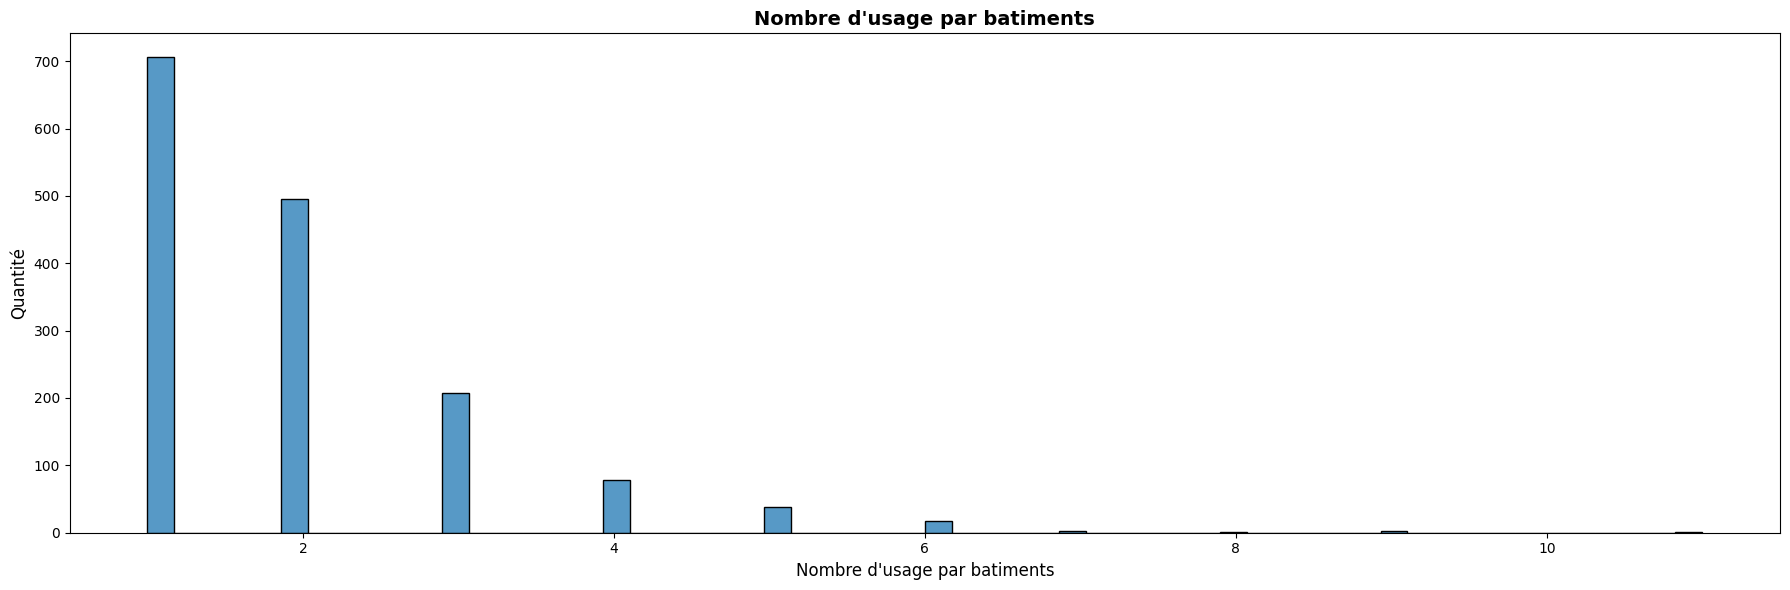

In [49]:
distribution_column(df, 'num_property_uses')

fig, axes = plt.subplots(1, 1, figsize=(18, 6))
create_hist(
    df,
    axes,
    "num_property_uses",
    "Nombre d'usage par batiments",
    "Nombre d'usage par batiments",
    "Quantité"
)
plt.tight_layout()
plt.show()

On peut maintenant supprimer `ListOfAllPropertyUseTypes` et `ListOfAllPropertyUseTypes_clean` qui ne seront pas utile pour le modèle redondant avec num_property_uses

In [50]:
df = remove_columns(df, ['ListOfAllPropertyUseTypes', 'ListOfAllPropertyUseTypes_clean'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1548, 46)
   ➤ Colonnes demandées    : 2
✅ Suppression terminée
   ➤ Shape finale          : (1548, 44)
   ➤ Colonnes supprimées   : 2
   🧹 Liste supprimée       : ['ListOfAllPropertyUseTypes', 'ListOfAllPropertyUseTypes_clean']


### 9.2. Colonnes > 20 % de donnée manquante

**Colonnes concernées :**
- `ENERGYSTARScore` (33.72% manquant) : Note calculée par l'EPA de 1 à 100 évaluant la performance énergétique globale d'une propriété, basée sur des données nationales pour contrôler les différences de climat, d'utilisations des bâtiments et d'opérations. Un score de 50 représente la médiane nationale.

**Analysons la colonne :**

In [51]:
display_columns_info(df, ['ENERGYSTARScore'])

┌─ 1. ENERGYSTARScore
│
│  🔢 Type: float64
│  🎯 Uniques: 100 (6.5%)
│  ⚠️ Manquantes: 551 (35.6%)
│  📈 Min: 1.00 | Max: 100.00 | Moyenne: 63.64
└──────────────────────────────────────────────────────────────────────────────



#### Décision sur ENERGYSTARScore

**Choix retenu : Suppression de la colonne**

**Justification :**

1. **Score non recalculable** : Le score ENERGYSTAR est calculé par l'EPA selon des modèles propriétaires et des données nationales de référence non disponibles dans notre dataset.

2. **Taux élevé de valeurs manquantes** : 25% des bâtiments (843/3376) n'ont pas de score, ce qui limiterait significativement l'utilité prédictive de cette variable.

3. **Risque de biais** : Toute imputation (moyenne, médiane, régression) introduirait un biais important dans les prédictions.

**Conclusion :** La suppression de cette colonne évite d'introduire du biais dans nos modèles prédictifs tout en conservant les variables énergétiques réellement mesurées qui sont nos vraies variables d'intérêt.


In [52]:
df = remove_columns(df, ['ENERGYSTARScore'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1548, 44)
   ➤ Colonnes demandées    : 1
✅ Suppression terminée
   ➤ Shape finale          : (1548, 43)
   ➤ Colonnes supprimées   : 1
   🧹 Liste supprimée       : ['ENERGYSTARScore']


## 10 Détection et traitement des outliers

### Gestion des outliers sur les variables cibles


Analyse des outliers – SiteEUI(kBtu/sf)
Observations : 1548
Moyenne : 75 | Médiane : 54
Z>2    →   75 outliers (4.84 %)
Z>3    →   28 outliers (1.81 %)
IQR    →  146 outliers (9.43 %)


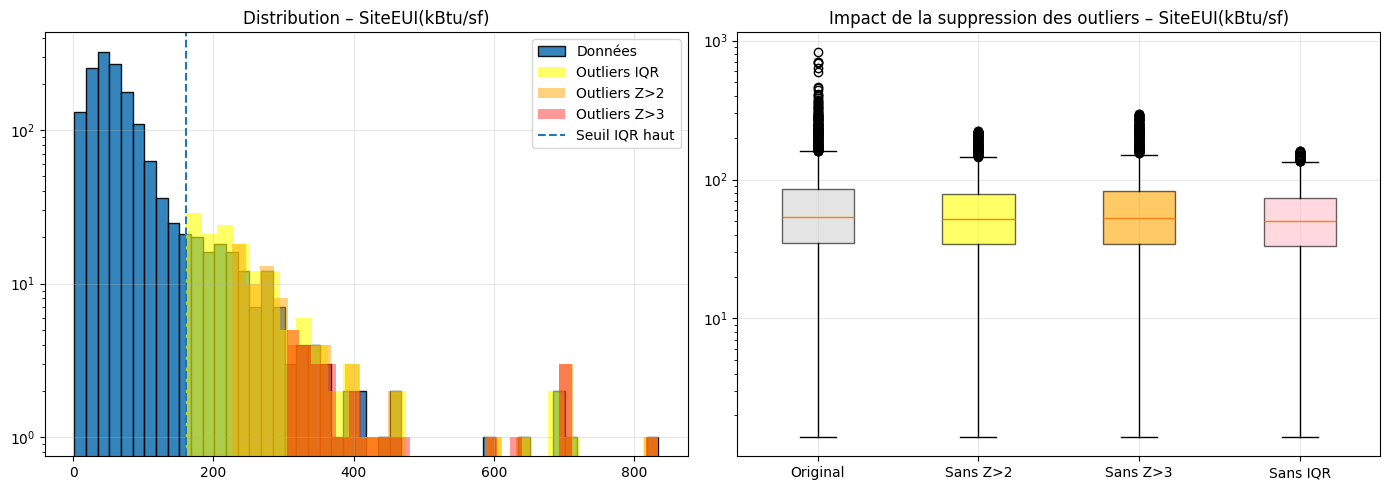


Analyse des outliers – GHGEmissionsIntensity
Observations : 1548
Moyenne : 2 | Médiane : 1
Z>2    →   69 outliers (4.46 %)
Z>3    →   32 outliers (2.07 %)
IQR    →  135 outliers (8.72 %)


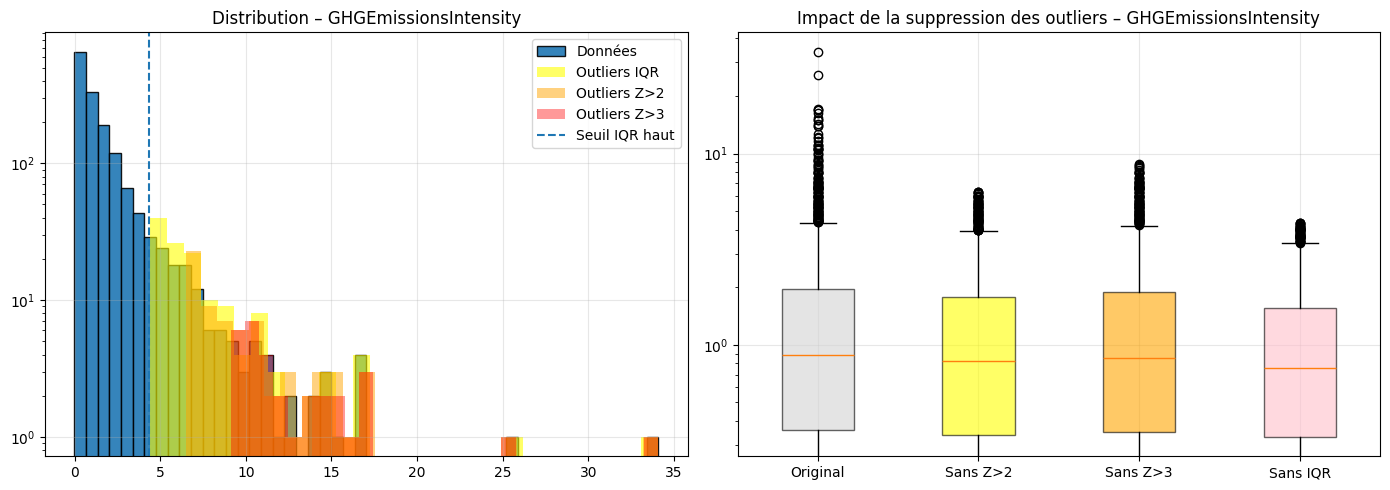

In [53]:
for cible in CIBLES:

    # =========================
    # PRÉPARATION DES DONNÉES
    # =========================
    s = df[cible]
    s_clean = s.dropna()

    # =========================
    # DÉTECTION DES OUTLIERS
    # =========================
    z = (s_clean - s_clean.mean()) / s_clean.std()

    Q1, Q3 = s_clean.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR

    masks = {
        "Z>2": z.abs() > 2,
        "Z>3": z.abs() > 3,
        "IQR": (s_clean < lower_iqr) | (s_clean > upper_iqr)
    }

    # Identification des outliers
    outliers_z2 = s_clean[masks["Z>2"]]
    outliers_z3 = s_clean[masks["Z>3"]]
    outliers_iqr = s_clean[masks["IQR"]]

    # Créer une colonne indicatrice
    df[f'{cible}_outlier_z_score_2'] = masks["Z>2"]
    df[f'{cible}_outlier_z_score_3'] = masks["Z>3"]
    df[f'{cible}_outlier_IQR'] = masks["IQR"]


    # =========================
    # RÉSULTATS
    # =========================
    print("\n" + "=" * 60)
    print(f"Analyse des outliers – {cible}")
    print("=" * 60)
    print(f"Observations : {len(s_clean)}")
    print(f"Moyenne : {s_clean.mean():,.0f} | Médiane : {s_clean.median():,.0f}")

    for name, mask in masks.items():
        print(f"{name:<6} → {mask.sum():>4} outliers ({mask.mean()*100:.2f} %)")


    # =========================
    # VISUALISATION
    # =========================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogramme
    axes[0].hist(s_clean, bins=50, alpha=0.9,  edgecolor="black", label="Données")
    axes[0].hist(outliers_iqr, bins=30, alpha=0.6, color='yellow', label="Outliers IQR")
    axes[0].hist(outliers_z2, bins=30, alpha=0.5, color='orange', label="Outliers Z>2")
    axes[0].hist(outliers_z3, bins=30, alpha=0.4, color='red', label="Outliers Z>3")

    axes[0].axvline(upper_iqr, linestyle="--", label="Seuil IQR haut")
    axes[0].set_yscale("log")
    axes[0].set_title(f"Distribution – {cible}")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Boxplot comparatif
    box_data = [
        s_clean,
        s_clean[~masks["Z>2"]],
        s_clean[~masks["Z>3"]],
        s_clean[~masks["IQR"]],
    ]

    bp = axes[1].boxplot(box_data, tick_labels=["Original", "Sans Z>2", "Sans Z>3", "Sans IQR"], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightgray', 'yellow', 'orange', 'pink']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].set_yscale("log")
    axes[1].set_title(f"Impact de la suppression des outliers – {cible}")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


### Analyse des Outliers - Variables Cibles

**Observations**

Les deux distributions sont fortement asymétriques à droite : la majorité des bâtiments présentent des valeurs faibles à modérées, tandis que quelques cas affichent des valeurs très élevées.

Les outliers se situent clairement dans la queue droite de la distribution, au-delà du seuil IQR. Ils influencent principalement les valeurs extrêmes et la variance, mais ont peu d'impact sur la médiane.

**Décision**

Nous allons supprimer les outliers via la méthode **Z-score > 3** pour les raisons suivantes : 
- Élimine uniquement les valeurs vraiment aberrantes (~2% des données)
- Préserve la variabilité nécessaire à l'entraînement du modèle
- Maintient des cas réels de bâtiments très énergivores, pertinents pour l'objectif de neutralité carbone 2050

La méthode IQR, bien que robuste, s'avère trop restrictive dans ce contexte (~9% de suppression) et risquerait d'éliminer des observations pertinentes du point de vue métier.


In [54]:
print("\n" + "="*80)
print("SUPPRESSION DES OUTLIERS")
print("="*80)
# Supprimer si outlier pour AU MOINS UNE des deux cibles (RECOMMANDÉ)
outliers_mask = df[TARGET_ENERGY + '_outlier_z_score_3'] | df[TARGET_CO2 + '_outlier_z_score_3']


print(f"\nNombre de bâtiments à supprimer : {outliers_mask.sum()} ({outliers_mask.sum()/len(df)*100:.1f}%)")

# Créer le DataFrame nettoyé
df_clean = df[~outliers_mask].copy()

# Supprimer les colonnes indicatrices (optionnel)
df_clean = remove_columns(df_clean, [
	TARGET_ENERGY + '_outlier_z_score_2', 
	TARGET_CO2 + '_outlier_z_score_2',
	TARGET_ENERGY + '_outlier_z_score_3', 
	TARGET_CO2 + '_outlier_z_score_3',
	TARGET_ENERGY + '_outlier_IQR', 
	TARGET_CO2 + '_outlier_IQR'
])

print(f"\nDimensions APRÈS suppression : {df_clean.shape}")
print(f"Nombre de bâtiments conservés : {len(df_clean)}")
print(f"Nombre de bâtiments supprimés : {len(df) - len(df_clean)}")

df = df_clean


SUPPRESSION DES OUTLIERS

Nombre de bâtiments à supprimer : 44 (2.8%)
📦 Suppression de colonnes
   ➤ Shape initiale        : (1504, 49)
   ➤ Colonnes demandées    : 6
✅ Suppression terminée
   ➤ Shape finale          : (1504, 43)
   ➤ Colonnes supprimées   : 6
   🧹 Liste supprimée       : ['SiteEUI(kBtu/sf)_outlier_z_score_2', 'GHGEmissionsIntensity_outlier_z_score_2', 'SiteEUI(kBtu/sf)_outlier_z_score_3', 'GHGEmissionsIntensity_outlier_z_score_3', 'SiteEUI(kBtu/sf)_outlier_IQR', 'GHGEmissionsIntensity_outlier_IQR']

Dimensions APRÈS suppression : (1504, 43)
Nombre de bâtiments conservés : 1504
Nombre de bâtiments supprimés : 44


### 10.1 Valeurs négatives

In [55]:
def display_columns_with_negatives(dataframe: pd.DataFrame) -> None:
    """
    Affiche les statistiques descriptives des colonnes numériques contenant des valeurs négatives.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Le DataFrame à analyser
    """
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns

    cols_with_negatives = numeric_cols[
        (dataframe[numeric_cols] < 0).any(axis=0)
    ]

    if len(cols_with_negatives) > 0:
        display(dataframe[cols_with_negatives].describe())
    else:
        print("Aucune colonne numérique ne contient de valeurs négatives.")


display_columns_with_negatives(df)

,Longitude,SourceEUIWN(kBtu/sf),Electricity(kWh),Electricity(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1504.000000,1504.000000,1.504000e+03,1.504000e+03,1504.000000,1504.000000
mean,-122.333529,167.063032,1.585384e+06,5.409331e+06,156.102540,1.395711
std,0.023047,128.427441,5.657967e+06,1.930498e+07,535.378673,1.532979
min,-122.411820,-2.100000,-3.382680e+04,-1.154170e+05,-0.800000,-0.020000
25%,-122.342848,81.775002,2.112401e+05,7.207515e+05,19.920000,0.350000
50%,-122.333160,137.750000,4.785429e+05,1.632788e+06,48.425000,0.840000
75%,-122.322830,204.774998,1.435926e+06,4.899381e+06,130.700000,1.870000
max,-122.261800,874.099976,1.925775e+08,6.570744e+08,12307.160000,8.670000


**Observation** :
On remarque que nous avons des valeurs négatives pour SourceEUIWN(kBtu/sf), Electricity(kWh), Electricity(kBtu), TotalGHGEmissions, GHGEmissionsIntensity cela signifierai que les batiments produirés plus de d'électricité par exemple que n'en produit.

Vérifions les lignes concernés

In [56]:
mask_negative_checks = (
    (df['SourceEUIWN(kBtu/sf)'] < 0) |
    (df['Electricity(kWh)'] < 0) |
    (df['Electricity(kBtu)'] < 0) |
    (df['TotalGHGEmissions'] < 0) |
    (df['GHGEmissionsIntensity'] < 0)
)

display(df[mask_negative_checks])


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,num_property_uses
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,48159.0,Pas d’usage,0.0,Pas d’usage,0.0,7.1,5.0,2.0,-2.1,342726.0938,240132.0938,0.0,-33826.80078,-115417.0,0.0,0.0,False,-0.8,-0.02,0,0,1


On constate que nous avons qu'un seul batiment possédant des valeurs négatives

Le bâtiment **Bullitt Center** est un bâtiment écologique, possédant des panneaux solaires, ce qui pourrait expliquer ces valeurs négatives.

Nous décidons de supprimer cette donnée car :
- Il s’agit d’un cas très spécifique de bâtiment à énergie positive (unique dans le dataset)
- Donnée non représentative de la population cible (bâtiments consommateurs d’énergie)
- Risque de fausser les modèles de prédiction

In [57]:
df = remove_lignes(df, "`Electricity(kWh)` < 0")

📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1504, 43)
✅ Suppression terminée
   ➤ Shape finale          : (1503, 43)
   ➤ Lignes supprimées     : 1 lignes


In [58]:
display_columns_with_negatives(df)

,Longitude
count,1503.000000
mean,-122.333543
std,0.023048
min,-122.411820
25%,-122.342855
50%,-122.333160
75%,-122.322840
max,-122.261800


### 10.2 Valeurs à zéro

In [59]:
def display_columns_with_zero(dataframe: pd.DataFrame) -> None:
    """
    Affiche les statistiques descriptives des colonnes numériques contenant des valeurs négatives.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Le DataFrame à analyser
    """
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
    cols_with_zero = numeric_cols[(dataframe[numeric_cols] == 0).any()]
    display(dataframe[cols_with_zero].describe())

display_columns_with_zero(df)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified
count,1503.000000,1503.000000,1503.000000,1.503000e+03,1503.000000,1503.000000,1502.000000,1503.000000,1503.000000,1.502000e+03,1.503000e+03,1.503000e+03,1.503000e+03,1503.000000,1.503000e+03,1503.000000,1503.000000,1503.000000,1503.000000
mean,1.174983,4.279441,14012.876248,9.849180e+04,19261.251029,3068.627677,69.093808,165.133999,167.175582,7.125644e+06,3.915091e+05,1.586461e+06,5.413006e+06,16616.624615,1.661662e+06,156.206933,1.396653,0.215569,0.063872
std,3.073119,6.820342,44173.381098,2.852099e+05,49373.685707,14684.714587,52.517600,128.440123,128.395966,1.462725e+07,4.389332e+06,5.659696e+06,1.931088e+07,50329.583187,5.032958e+06,535.541553,1.533054,1.083761,0.244607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,2.500000e+04,0.000000,0.000000,36.500000,79.500000,81.900002,1.295210e+06,0.000000e+00,2.115199e+05,7.217060e+05,0.000000,0.000000e+00,20.005000,0.350000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,4.195800e+04,0.000000,0.000000,55.299999,136.399994,138.000000,2.736046e+06,0.000000e+00,4.786357e+05,1.633105e+06,4595.079590,4.595080e+05,48.500000,0.840000,0.000000,0.000000
75%,1.000000,4.000000,0.000000,9.179000e+04,13575.500000,0.000000,85.025000,203.099998,204.849998,6.866333e+06,0.000000e+00,1.436401e+06,4.901002e+06,14098.856935,1.409886e+06,130.710000,1.870000,0.000000,0.000000
max,111.000000,99.000000,512608.000000,9.320156e+06,441551.000000,303910.000000,311.100006,874.099976,874.099976,2.959299e+08,1.349435e+08,1.925775e+08,6.570744e+08,846680.937500,8.466809e+07,12307.160000,8.670000,15.000000,1.000000


### **Observation**

Certaines colonnes contiennent des valeurs égales à 0. Pour plusieurs d’entre elles, ces valeurs sont **justifiables** et ne traduisent pas nécessairement une anomalie.

| Colonne | Raison |
|--------|--------|
| `PropertyGFAParking` | Un bâtiment n’est pas obligatoirement doté d’un parking. |
| `NaturalGas(therms)` | De nombreux bâtiments sont aujourd’hui entièrement électriques. |
| `NaturalGas(kBtu)` | De nombreux bâtiments sont aujourd’hui entièrement électriques. |
| `SteamUse (kBtu)` | Indique la consommation annuelle de vapeur. Tous les bâtiments ne sont pas raccordés à un réseau de vapeur. |
| `SecondLargestPropertyUseTypeGFA` | Le bâtiment ne possède pas de second type d’usage. |
| `ThirdLargestPropertyUseTypeGFA` | Le bâtiment ne possède pas de troisième type d’usage. |

Les colonnes suivantes feront l’objet d’une analyse approfondie afin de comprendre l’origine des valeurs nulles :

- `GHGEmissionsIntensity`
- `NumberofBuildings`
- `NumberofFloors`

En revanche, les autres colonnes énergétiques seront **supprimées** afin d’éviter tout risque de *data leakage*.


#### Vérification sur les variables cibles

In [60]:
zero_value_checks = (
    (df[TARGET_CO2] == 0) |
    (df[TARGET_ENERGY] == 0)
)

display(df[zero_value_checks])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,num_property_uses
513,700,2016,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,2001 15th Avenue West,Seattle,WA,98119.0,7666201460,7,MAGNOLIA / QUEEN ANNE,47.63718,-122.37734,2008,1.0,1,57176,0,57176,Supermarket/Grocery Store,39500.0,Retail Store,15000.0,"Personal Services (Health/Beauty, Dry Cleaning...",5500.0,208.800003,214.100006,0.0,0.0,12525174.0,12843856.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0,0,3


**Observations**  
Nous n’avons qu’un seul bâtiment avec une valeur de **GHGEmissionsIntensity** égale à zéro.  
On constate également que plusieurs colonnes liées aux consommations énergétiques présentent des valeurs nulles.  

Cela semble peu plausible pour un supermarché. Nous préférons donc exclure cette observation afin d’éviter de biaiser les modèles.


In [61]:
df = remove_lignes(df, f"`{TARGET_CO2}` == 0 or `{TARGET_ENERGY}` == 0")

📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1503, 43)
✅ Suppression terminée
   ➤ Shape finale          : (1502, 43)
   ➤ Lignes supprimées     : 1 lignes


#### Colonne NumberofBuildings

In [62]:
print("\n🔧 Nombre de batiments avec 0 bâtiment : {}".format(df[df['NumberofBuildings'] == 0].shape[0]))
display(df[df['NumberofBuildings'] == 0].head(2))


🔧 Nombre de batiments avec 0 bâtiment : 49


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,num_property_uses
63,89,2016,NonResidential,Medical Office,Polyclinic North && South,1200 Harvard Ave,Seattle,WA,98122.0,1978201270,3,EAST,47.61244,-122.32140,1965,0.0,3,179014,0,179014,Medical Office,179014.0,Pas d’usage,0.0,Pas d’usage,0.0,93.300003,92.300003,213.399994,210.300003,16701055.00,16527711.00,0.0,2897562.75,9886484.0,68145.70313,6814570.0,False,430.84,2.41,0,0,1
76,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,Seattle,WA,98109.0,1988200705,7,MAGNOLIA / QUEEN ANNE,47.62391,-122.34837,1986,0.0,2,66240,2352,63888,Office,45900.0,Data Center,5181.0,Distribution Center,4551.0,74.900002,75.400002,235.199997,236.600006,4166306.25,4192107.75,0.0,1221074.25,4166305.0,0.00000,0.0,False,29.04,0.44,0,0,5


In [63]:
median_building_by_type = df.groupby('PrimaryPropertyType')['NumberofBuildings'].median()
display(median_building_by_type)
distribution_column(df[df['NumberofBuildings'] == 0], 'PrimaryPropertyType')


PrimaryPropertyType
Distribution Center            1.0
Hospital                       4.0
Hotel                          1.0
K-12 School                    1.0
Laboratory                     1.0
Large Office                   1.0
Low-Rise Multifamily           1.0
Medical Office                 1.0
Mixed Use Property             1.0
Other                          1.0
Refrigerated Warehouse         1.0
Residence Hall                 1.0
Restaurant                     1.0
Retail Store                   1.0
Self-Storage Facility          1.0
Senior Care Community          1.0
Small- and Mid-Sized Office    1.0
Supermarket / Grocery Store    1.0
University                     1.0
Warehouse                      1.0
Worship Facility               1.0
Name: NumberofBuildings, dtype: float64

📊 Distribution de la colonne PrimaryPropertyType
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
PrimaryPropertyType,,
Other,11,22.45
Small- and Mid-Sized Office,10,20.41
Mixed Use Property,6,12.24
Large Office,4,8.16
Warehouse,3,6.12
Retail Store,3,6.12
Medical Office,2,4.08
Hotel,2,4.08
Supermarket / Grocery Store,2,4.08


**Décision** : Nous pouvons imputer sur la médiane par rapport au type de batiment et en même temps on en profite pour corrigé le type de donnée qui devrait être en entier.

In [64]:
df['NumberofBuildings'] = df['NumberofBuildings'].mask(
    df['NumberofBuildings'] == 0,
    df['PrimaryPropertyType'].map(median_building_by_type)
)

In [65]:
df["NumberofBuildings"] = df["NumberofBuildings"].astype("Int64")

#### Colonne NumberofFloors

In [66]:
print("\n🔧 Nombre de batiments avec 0 étage : {}".format(df[df['NumberofFloors'] == 0].shape[0]))
display(df[df['NumberofFloors'] == 0].head(2))


🔧 Nombre de batiments avec 0 étage : 16


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,num_property_uses
166,267,2016,NonResidential,Hotel,Grand Hyatt Seattle,721 Pine St,Seattle,WA,98101.0,6792120000,7,DOWNTOWN,47.61275,-122.33330,1999,1,0,934292,0,934292,Hotel,495536.0,Parking,438756.0,Restaurant,49700.0,117.900002,120.500000,272.899994,278.200012,65047284.0,66502836.0,0.0,11536962.00,39364114.0,256831.625,25683162.0,False,1638.46,1.75,0,0,5
487,656,2016,NonResidential,Medical Office,Arnold Pavilion,1221 Madison Street,Seattle,WA,98104.0,8725990000,3,EAST,47.60979,-122.32298,2004,1,0,225982,0,225982,Medical Office,200184.0,Pas d’usage,0.0,Pas d’usage,0.0,102.699997,103.699997,246.899994,245.300003,20560622.0,20764814.0,7815663.0,3735333.25,12744957.0,0.000,0.0,False,692.12,3.06,0,0,1


**Observation**:
Tout bâtiment a au moins 1 étage, nous allons l'imputé via la médianne par type de propriété

In [67]:
median_floors_by_type = df.groupby('PrimaryPropertyType')['NumberofFloors'].median()

df.loc[df['NumberofFloors'] == 0, 'NumberofFloors'] = df.loc[df['NumberofFloors'] == 0, 'PrimaryPropertyType'].map(median_floors_by_type)



### 10.3 Valeurs abérrantes

In [68]:
critere = df['NumberofBuildings'] >= 9
col = [
    'PropertyName',
	'BuildingType',
	'PrimaryPropertyType',
	'YearBuilt',
	'NumberofBuildings',
	'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)'
]
print(len(df[critere]))
display(df[critere][col].sort_values(by='NumberofBuildings'))

7


,PropertyName,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)
1993,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,Campus,Other,1991,10,2,230971,0,230971
128,NSCC MAIN CAMPUS,Campus,University,1970,11,2,694072,111625,582447
2325,5th Avenue Master Meter,Campus,University,1945,14,2,537000,0,537000
162,South Park,Campus,Large Office,1980,14,2,334368,31874,302494
1862,FT C15 Fishermen's Center,Campus,Other,1955,23,1,260241,0,260241
105,SSCC MAIN CAMPUS,Campus,University,1970,27,2,441071,0,441071
3274,University of Washington - Seattle Campus,Campus,University,1900,111,2,9320156,0,9320156


**Observations**

Le nombre de batiment semble cohérent même pour *University of Washington - Seattle Campus* qui à 111 batiments, une simple recherche sur internet nous permet de voir que ce chiffre est correct.


In [69]:
critere = df['NumberofFloors'] >= 50
col = [
    'PropertyName',
	'Adress'
	'BuildingType',
	'PrimaryPropertyType',
	'YearBuilt',
	'NumberofBuildings',
	'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)'
]
print(len(df[critere]))
display(df[critere].sort_values(by='NumberofBuildings'))

5


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,num_property_uses
233,357,2016,Nonresidential COS,Large Office,Seattle Municipal Tower (2030),700 Fifth Avenue,Seattle,WA,98104.0,0942000720,3,DOWNTOWN,47.60501,-122.32988,1990,1,63,1354987,159600,1195387,Office,1191115.0,Parking,159599.0,Other,18656.0,50.400002,50.400002,158.100006,158.100006,6.157618e+07,6.157618e+07,0.000,18046946.0,61576180.0,0.00000,0.0,False,429.27,0.32,7,1,3
271,399,2016,NonResidential,Large Office,1201 Third Avenue,1201 3rd ave,Seattle,WA,98101.0,1974700120,7,DOWNTOWN,47.60723,-122.33611,1988,1,55,1400000,285000,1115000,Office,994116.0,Parking,264481.0,Other,133598.0,46.700001,48.500000,140.199997,145.300003,5.307916e+07,5.514030e+07,2179487.750,14499658.0,49472833.0,14268.40039,1426840.0,False,588.90,0.42,4,1,4
292,422,2016,NonResidential,Large Office,Two Union Square,601 Union St.,Seattle,WA,98101.0,1976700125,7,DOWNTOWN,47.61043,-122.33206,1989,1,56,1605578,389860,1215718,Office,1314475.0,Parking,389860.0,Other,30744.0,36.799999,37.900002,110.300003,113.300003,4.951770e+07,5.098450e+07,915654.875,13505807.0,46081813.0,25202.29883,2520230.0,False,525.78,0.33,2,1,3
559,775,2016,NonResidential,Large Office,Columbia Center - 2015,701 5th Avenue,Seattle,WA,98104.0,0942000640,7,DOWNTOWN,47.60454,-122.33072,1985,1,76,1952220,319400,1632820,Office,1680937.0,Pas d’usage,319368.0,Pas d’usage,0.0,55.299999,55.099998,167.300003,166.500000,9.293764e+07,9.253726e+07,0.000,25747908.0,87851862.0,50857.63281,5085763.0,False,882.56,0.45,7,1,2
1359,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,5801 Beacon Avenue South,Seattle,WA,98108.0,2124049098,2,GREATER DUWAMISH,47.55072,-122.30265,1977,1,99,21948,0,21948,Worship Facility,21948.0,Pas d’usage,0.0,Pas d’usage,0.0,14.900000,14.900000,46.599998,46.599998,3.260012e+05,3.260012e+05,0.000,95545.5,326001.0,0.00000,0.0,False,2.27,0.10,0,0,1


**Observations**

Seul le bâtiment *Seattle Chinese Baptist Church* semble présenter une valeur aberrante pour le nombre d’étages : 99 étages, ce qui est excessivement élevé pour une église.  
De plus, la consultation de Wikipédia, qui recense les bâtiments les plus hauts de Seattle, permet de valider les valeurs des autres bâtiments. Cette source confirme que l’église constitue une anomalie et nécessite une correction.  
https://fr.wikipedia.org/wiki/Liste_des_plus_hautes_constructions_de_Seattle

**Décision**

Nous allons corriger cette valeur en utilisant la médiane de *NumberOfFloors* pour la catégorie **Worship Facilities**.

In [70]:
# Calculer la médiane des NumberofFloors pour les Worship Facilities
median_worship = df[df['PrimaryPropertyType'] == 'Worship Facility']['NumberofFloors'].median()
print(f"Médiane des étages pour les lieux de culte : {median_worship:.0f}")

# Corriger la valeur aberrante
df.loc[df['NumberofFloors'] == 99, 'NumberofFloors'] = median_worship

# Vérifier la correction
print(f"\n✅ Correction effectuée !")
print(f"Nouvelle valeur pour Seattle Chinese Baptist Church : {median_worship:.0f} étages")

Médiane des étages pour les lieux de culte : 2

✅ Correction effectuée !
Nouvelle valeur pour Seattle Chinese Baptist Church : 2 étages


## Suppression des colonnes

##### Identifiants uniques (4)
Ces colonnes identifient de manière unique chaque bâtiment mais n'apporte pas de valeur prédictif pour le modèle

| Colonne | Raison |
|---------|--------|
| `OSEBuildingID` | Identifiant système unique par bâtiment |
| `PropertyName` | Nom propre du bâtiment (ex: "Mayflower Park Hotel") |
| `Address` | Adresse complète spécifique à chaque bâtiment |
| `TaxParcelIdentificationNumber` | Numéro de parcelle fiscale unique |

In [71]:
low_predictive_value_columns = [
	'OSEBuildingID', 
    'PropertyName', 
    'Address', 
    'TaxParcelIdentificationNumber',
]
display_columns_info(df, low_predictive_value_columns)

┌─ 1. OSEBuildingID
│
│  🔢 Type: int64
│  🎯 Uniques: 1,502 (100.0%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 1.00 | Max: 50226.00 | Moyenne: 16368.12
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. PropertyName
│
│  🔤 Type: object
│  🎯 Uniques: 1,498 (99.7%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 3. Address
│
│  🔤 Type: object
│  🎯 Uniques: 1,481 (98.6%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 4. TaxParcelIdentificationNumber
│
│  🔤 Type: object
│  🎯 Uniques: 1,425 (94.9%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────



In [72]:
df = remove_columns(df, low_predictive_value_columns)

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 43)
   ➤ Colonnes demandées    : 4
✅ Suppression terminée
   ➤ Shape finale          : (1502, 39)
   ➤ Colonnes supprimées   : 4
   🧹 Liste supprimée       : ['OSEBuildingID', 'PropertyName', 'Address', 'TaxParcelIdentificationNumber']


### Colonnes à valeur unique
Ces colonnes contiennent la même valeur pour tous les bâtiments, elles n'apportent donc aucune variabilité ni pouvoir discriminant.

| Colonne | Valeur unique | Raison |
|---------|---------------|--------|
| `DataYear` | 2016 | Toutes les observations datent de 2016 |
| `City` | Seattle | Tous les bâtiments sont situés à Seattle |
| `State` | WA | Tous les bâtiments sont dans l'État de Washington |
| `DefaultData` | Booléen | Indique si les données sont estimées ou réelles |

In [73]:
low_predictive_value_columns = [
    'DataYear', 
    'City', 
    'State',
	'DefaultData',
]
display_columns_info(df, low_predictive_value_columns)

┌─ 1. DataYear
│
│  🔢 Type: int64
│  🎯 Uniques: 1 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: 2016
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. City
│
│  🔤 Type: object
│  🎯 Uniques: 1 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: Seattle
└──────────────────────────────────────────────────────────────────────────────

┌─ 3. State
│
│  🔤 Type: object
│  🎯 Uniques: 1 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: WA
└──────────────────────────────────────────────────────────────────────────────

┌─ 4. DefaultData
│
│  🔢 Type: bool
│  🎯 Uniques: 1 (0.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: False
└──────────────────────────────────────────────────────────────────────────────



In [74]:
df = remove_columns(df, low_predictive_value_columns)

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 39)
   ➤ Colonnes demandées    : 4
✅ Suppression terminée
   ➤ Shape finale          : (1502, 35)
   ➤ Colonnes supprimées   : 4
   🧹 Liste supprimée       : ['DataYear', 'City', 'State', 'DefaultData']


### Colonnes géographiques

In [75]:
colonnes_geo = ['ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude']
display_columns_info(df, colonnes_geo)

┌─ 1. ZipCode
│
│  🔢 Type: float64
│  🎯 Uniques: 47 (3.1%)
│  ⚠️ Manquantes: 10 (0.7%)
│  📈 Min: 98006.00 | Max: 98199.00 | Moyenne: 98116.94
└──────────────────────────────────────────────────────────────────────────────

┌─ 2. CouncilDistrictCode
│
│  🔢 Type: int64
│  🎯 Uniques: 7 (0.5%)
│  ✅ Manquantes: 0 (0.0%)
│  📋 Valeurs: 7, 3, 4, 2, 6, 1, 5
└──────────────────────────────────────────────────────────────────────────────

┌─ 3. Neighborhood
│
│  🔤 Type: object
│  🎯 Uniques: 19 (1.3%)
│  ✅ Manquantes: 0 (0.0%)
└──────────────────────────────────────────────────────────────────────────────

┌─ 4. Latitude
│
│  🔢 Type: float64
│  🎯 Uniques: 1,353 (90.1%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: 47.51 | Max: 47.73 | Moyenne: 47.62
└──────────────────────────────────────────────────────────────────────────────

┌─ 5. Longitude
│
│  🔢 Type: float64
│  🎯 Uniques: 1,266 (84.3%)
│  ✅ Manquantes: 0 (0.0%)
│  📈 Min: -122.41 | Max: -122.26 | Moyenne: -122.33
└─────────────────────────────────────

### Sélection des variables géographiques

| Colonne | Décision | Justification |
|--------|----------|---------------|
| ZipCode | Supprimée | Trop précise, forte cardinalité, apporte du bruit au modèle. |
| CouncilDistrictCode | Supprimée | Découpage administratif large, peu informatif pour la prédiction. |
| Neighborhood | Conservée | Bon compromis entre précision géographique et généralisation du modèle. |
| Latitude | Supprimée | Valeurs quasi uniques, difficiles à exploiter directement en ML. |
| Longitude | Supprimée | Même problème que Latitude, peu généralisable sans transformation. |

**Conclusion :**  
Seule la variable `Neighborhood` est conservée afin de limiter le bruit et le risque de sur-apprentissage tout en gardant une information géographique pertinente.


Vérifions que les données de `Neighborhood` afin de s'assurer de notre choix

In [76]:
distribution_column(df, 'Neighborhood')

📊 Distribution de la colonne Neighborhood
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
Neighborhood,,
DOWNTOWN,344,22.90
GREATER DUWAMISH,326,21.70
LAKE UNION,140,9.32
MAGNOLIA / QUEEN ANNE,138,9.19
NORTHEAST,110,7.32
EAST,107,7.12
NORTHWEST,73,4.86
BALLARD,55,3.66
NORTH,50,3.33


Il n’y a aucune donnée manquante, mais la colonne doit être nettoyée car elle contient des doublons :
- **BALLARD** (majuscules) et **Ballard** (minuscules)
- Même problème pour **DELRIDGE NEIGHBORHOODS** et **Delridge**
- Même problème pour **CENTRAL** et **Central**

In [77]:
df["Neighborhood"] = df["Neighborhood"].str.upper()
df["Neighborhood"] = df["Neighborhood"].replace(
    "DELRIDGE NEIGHBORHOODS",
    "DELRIDGE"
)

distribution_column(df, 'Neighborhood')

📊 Distribution de la colonne Neighborhood
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
Neighborhood,,
DOWNTOWN,344,22.90
GREATER DUWAMISH,326,21.70
LAKE UNION,140,9.32
MAGNOLIA / QUEEN ANNE,138,9.19
NORTHEAST,110,7.32
EAST,107,7.12
NORTHWEST,77,5.13
BALLARD,60,3.99
NORTH,58,3.86


In [78]:
df = remove_columns(df,  ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 35)
   ➤ Colonnes demandées    : 4
✅ Suppression terminée
   ➤ Shape finale          : (1502, 31)
   ➤ Colonnes supprimées   : 4
   🧹 Liste supprimée       : ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude']


###  Suppression des colonnes causant du data leakage

**Qu'est-ce que le data leakage ?**

Le **data leakage** (fuite de données) se produit quand des informations de la cible sont utilisées dans les features d'entraînement. Cela crée une **performance artificielle** en entraînement mais un **échec total** en production.


| Colonne | Explication détaillée |
|---------|----------------------|
| `SiteEUIWN(kBtu/sf)` | Version "Weather Normalized" de `SiteEUI(kBtu/sf)`. |
| `SourceEUI(kBtu/sf)` | **Source Energy Use Intensity** incluant les pertes de distribution (transport électricité, etc.). Calculée à partir de la consommation réelle. |
| `SourceEUIWN(kBtu/sf)` | Version normalisée de `SourceEUI`. Dérivée de consommations réelles + ajustements météo. |
| `SiteEnergyUse(kBtu)` |  |
| `SiteEnergyUseWN(kBtu)` | Version "Weather Normalized" de votre target `SiteEnergyUse(kBtu)`. |
| `TotalGHGEmissions` |  |

Ces colonnes vont également entrainner du dataleakage cependant nous pouvont en tiret des  nouvelle feature utile pour notre modele 

| Colonne | Explication détaillée |
|---------|----------------------|
| `Electricity(kBtu)` | Cette variable **constitue directement la cible**. C'est un terme de la somme : `SiteEnergyUse(kBtu) = Electricity(kBtu) + NaturalGas(kBtu) + SteamUse(kBtu)` et `SiteEUI(kBtu/sf) = SiteEnergyUse(kBtu) / Surface`. Prédire une somme en utilisant l’un de ses termes revient à un leakage parfait. |
| `Electricity(kWh)` | Identique à `Electricity(kBtu)` mais en unités différentes |
| `NaturalGas(kBtu)` | Même raisonnement que  `Electricity(kBtu)`  |
| `NaturalGas(therms)` | Identique à `NaturalGas(kBtu)` mais en unités différentes |
| `SteamUse(kBtu)` | Même raisonnement que  `Electricity(kBtu)` |

In [79]:
colonnes_leakage = [
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'TotalGHGEmissions'
]

df = remove_columns(df,colonnes_leakage)

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 31)
   ➤ Colonnes demandées    : 6
✅ Suppression terminée
   ➤ Shape finale          : (1502, 25)
   ➤ Colonnes supprimées   : 6
   🧹 Liste supprimée       : ['SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']


## 11 Résumé après nettoyage

In [80]:
df.to_csv('data/data_essaie.csv', index=False)

print("="*80)
print("📊 ANALYSE DES VALEURS MANQUANTES")
print("="*80)

print(f"\n🔧 Shape du DataFrame avant traitement des valeurs manquantes : {df.shape}")

missing_stats = analyze_missing_values(df, True)

print(f"\n Distribution finale des valeurs numériques après nettoyage :")
display(df.describe())

print(f"\n Informations sur le DataFrame final :")
display(df.info())

📊 ANALYSE DES VALEURS MANQUANTES

🔧 Shape du DataFrame avant traitement des valeurs manquantes : (1502, 25)

🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%

 Distribution finale des valeurs numériques après nettoyage :


,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissionsIntensity,num_years_certified,is_energy_star_certified,num_property_uses
count,1502.000000,1502.0,1502.000000,1.502000e+03,1502.000000,1.502000e+03,1.502000e+03,1502.000000,1502.000000,1502.000000,1.502000e+03,1.502000e+03,1.502000e+03,1502.000000,1.502000e+03,1502.000000,1502.000000,1502.000000,1502.000000
mean,1961.434088,1.20972,4.246338,1.210308e+05,14022.205726,1.070086e+05,9.853107e+04,19264.088080,3067.008921,66.707923,3.917697e+05,1.587518e+06,5.416610e+06,16627.687614,1.662769e+06,1.397583,0.215712,0.063915,1.913449
std,32.938145,3.06763,6.357067,3.085442e+05,44186.612026,2.945573e+05,2.853008e+05,49390.007349,14689.471272,51.533988,4.390782e+06,5.661433e+06,1.931681e+07,50344.517629,5.034452e+06,1.533140,1.084108,0.244683,1.156262
min,1900.000000,1.0,1.000000,1.128500e+04,0.000000,1.092500e+04,0.000000e+00,0.000000,0.000000,1.400000,0.000000e+00,1.000000e+00,3.000000e+00,0.000000,0.000000e+00,0.010000,0.000000,0.000000,1.000000
25%,1930.000000,1.0,1.000000,2.882525e+04,0.000000,2.796150e+04,2.500000e+04,0.000000,0.000000,34.400002,0.000000e+00,2.117995e+05,7.226602e+05,0.000000,0.000000e+00,0.350000,0.000000,0.000000,1.000000
50%,1965.000000,1.0,2.000000,4.831500e+04,0.000000,4.626150e+04,4.204300e+04,0.000000,0.000000,52.700001,0.000000e+00,4.786651e+05,1.633206e+06,4596.749756,4.596750e+05,0.845000,0.000000,0.000000,2.000000
75%,1988.000000,1.0,4.000000,1.073940e+05,0.000000,9.530650e+04,9.186250e+04,13538.500000,0.000000,81.225002,0.000000e+00,1.436876e+06,4.902622e+06,14103.443117,1.410344e+06,1.870000,0.000000,0.000000,2.000000
max,2015.000000,111.0,76.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,441551.000000,303910.000000,298.299988,1.349435e+08,1.925775e+08,6.570744e+08,846680.937500,8.466809e+07,8.670000,15.000000,1.000000,11.000000



 Informations sur le DataFrame final :
<class 'pandas.core.frame.DataFrame'>
Index: 1502 entries, 0 to 3375
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1502 non-null   object 
 1   PrimaryPropertyType              1502 non-null   object 
 2   Neighborhood                     1502 non-null   object 
 3   YearBuilt                        1502 non-null   int64  
 4   NumberofBuildings                1502 non-null   Int64  
 5   NumberofFloors                   1502 non-null   int64  
 6   PropertyGFATotal                 1502 non-null   int64  
 7   PropertyGFAParking               1502 non-null   int64  
 8   PropertyGFABuilding(s)           1502 non-null   int64  
 9   LargestPropertyUseType           1502 non-null   object 
 10  LargestPropertyUseTypeGFA        1502 non-null   float64
 11  SecondLargestPropertyUseType     1502 non-null 

None

## 12. ......

### 12.1. Quantitative vs Quantitative

**Objectif :** Mesurer la relation linéaire entre deux variables numériques.

**Graphiques :**
- Scatter plot (nuage de points)
- Matrice de corrélation (heatmap)

### Émissions GES vs Consommation d'énergie

In [81]:
plt.style.use('seaborn-v0_8-darkgrid')
# sns.set_palette("husl")
pd.set_option('display.max_columns', None)

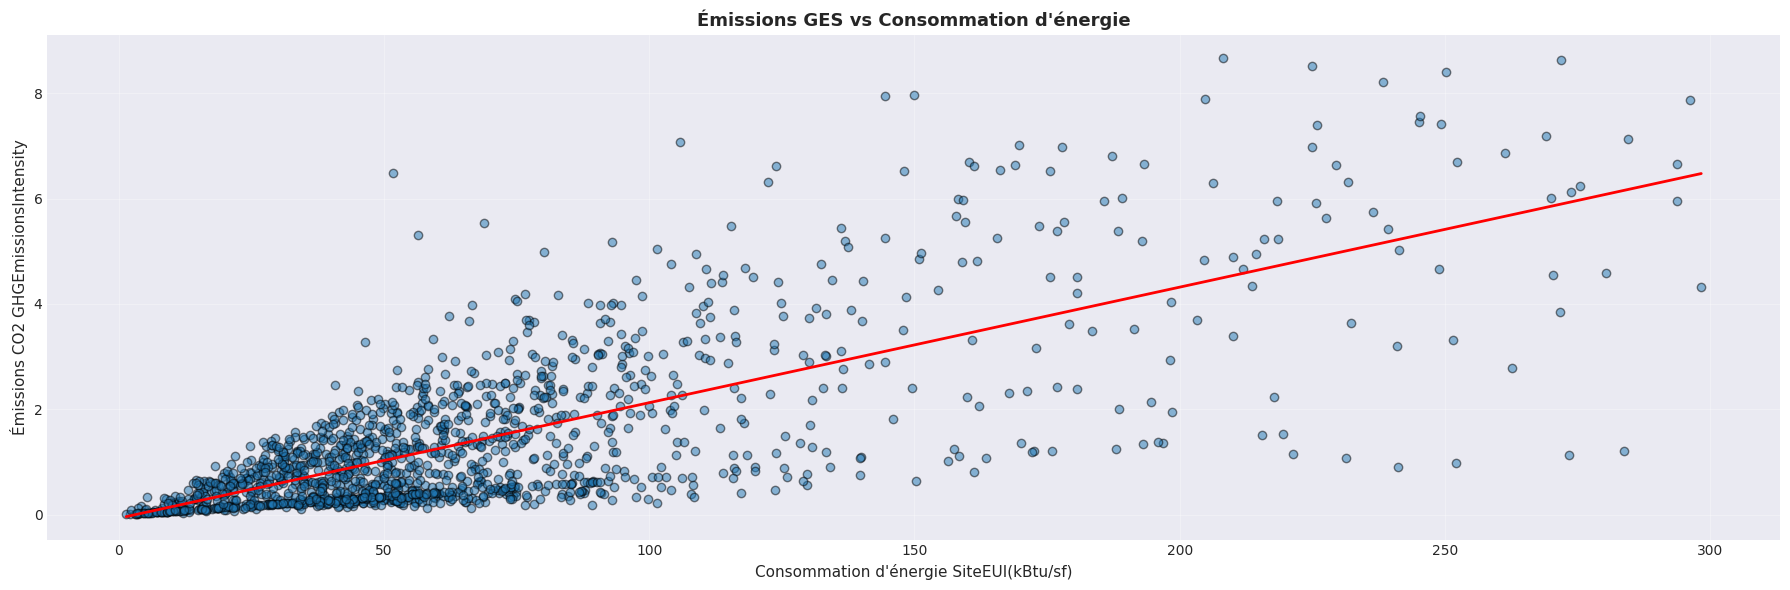

In [82]:
def create_scatter(
    df: pd.DataFrame,
    x: str,
    y: str,
    title: str,
    xlabel: str,
    ylabel: str,
    ax: plt.Axes,
    add_trendline: bool = False
):
    if add_trendline:
        sns.regplot(
            data=df,
            x=x,
            y=y,
            ax=ax,
            scatter_kws={
                "alpha": 0.5,
                "edgecolor": "k"
            },
            line_kws={
                "color": "red",
                "linewidth": 2
            },
            ci=None
        )
    else:
        sns.scatterplot(
            data=df,
            x=x,
            y=y,
            ax=ax,
            alpha=0.5,
            edgecolor="k"
        )

    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.grid(True, alpha=0.3)

fig, axe = plt.subplots(1, 1, figsize=(18, 6))

create_scatter(
    df,
    TARGET_ENERGY,
    TARGET_CO2,
    "Émissions GES vs Consommation d'énergie",
    f"Consommation d'énergie {TARGET_ENERGY}",
    f"Émissions CO2 {TARGET_CO2}",
    axe,
    True
)
plt.tight_layout()
plt.show()



**Observations**

- On observe une relation linéaire claire entre la consommation d'énergie et les émissions de CO2. Plus un bâtiment consomme d'énergie, plus il émet de GES. La ligne de régression rouge confirme cette tendance.
- Même si la tendance est visible, il y a beaucoup de points éparpillés autour de la ligne de régression. Ça veut dire que deux bâtiments avec la même consommation peuvent avoir des émissions très différentes.
- La majorité des points sont regroupés dans la zone 0-150 kBtu/sf avec des émissions faibles. Ça signifie que la plupart des bâtiments sont relativement efficaces énergétiquement.
- Il y a quelques points isolés en haut à droite (consommation > 250 kBtu/sf, émissions > 6). Ces bâtiments sont probablement des cas particuliers à analyser (industrie lourde, datacenters, etc.).


### Consommation energie et émission de CO2 vs Surface totale

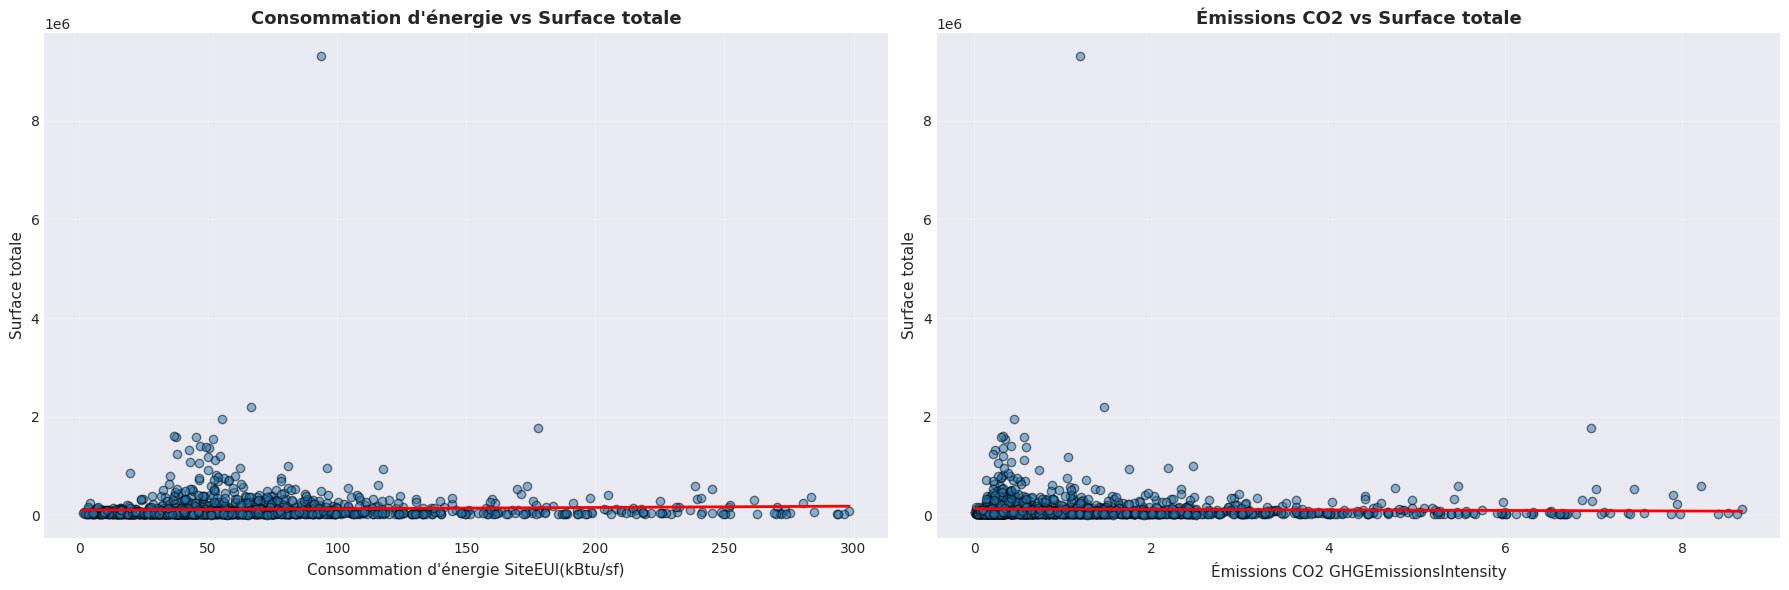

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

create_scatter(
    df,
    TARGET_ENERGY,
    "PropertyGFATotal",
    "Consommation d'énergie vs Surface totale",
    f"Consommation d'énergie {TARGET_ENERGY}",
    "Surface totale",
    axes[0],
    True
)

create_scatter(
    df,
    TARGET_CO2,
    "PropertyGFATotal",
    "Émissions CO2 vs Surface totale",
    f"Émissions CO2 {TARGET_CO2}",
    "Surface totale",
    axes[1],
    True
)
plt.tight_layout()
plt.show()

### Année de construction vs Intensité énergétique

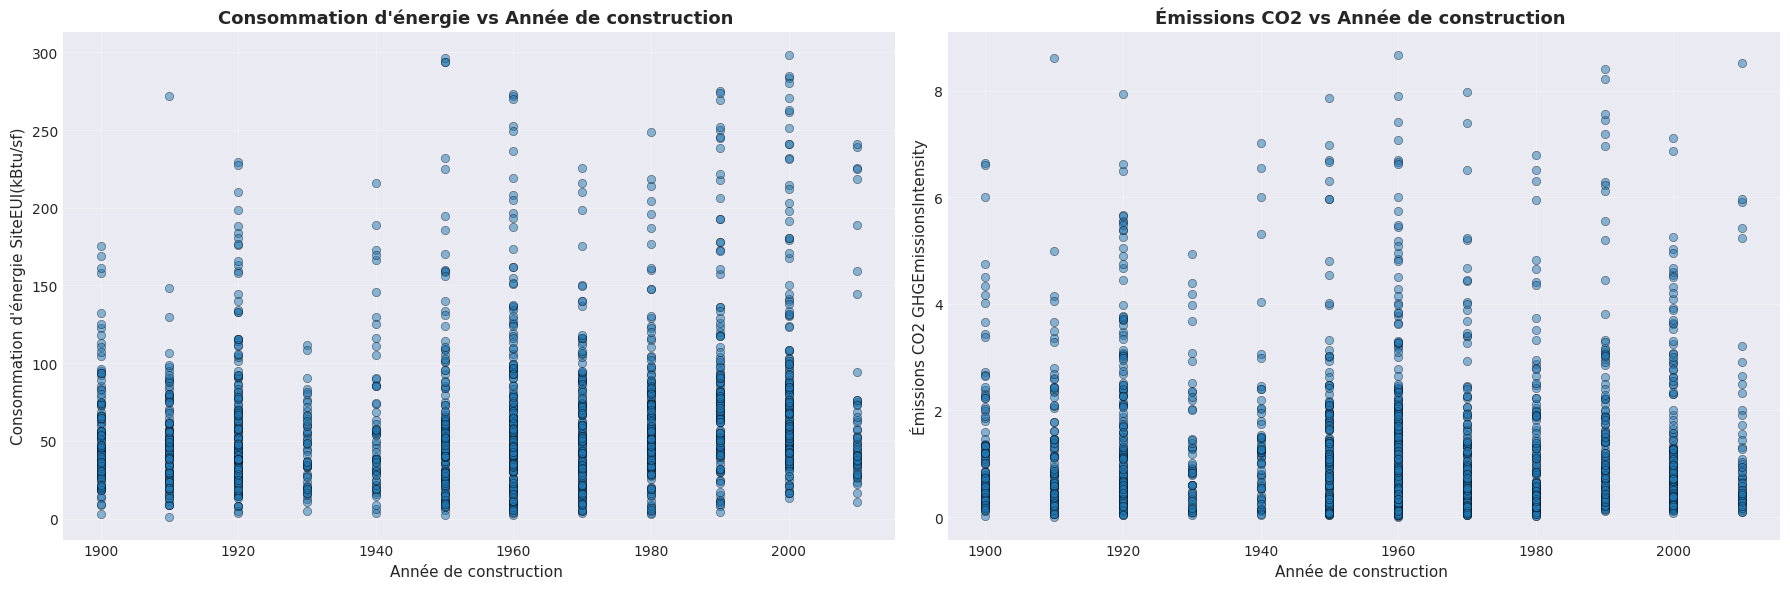

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
df_copy = df.copy()
df_copy['decennie'] = (df_copy['YearBuilt'] // 10) * 10

create_scatter(
    df_copy,
    "decennie",
    TARGET_ENERGY,
    "Consommation d'énergie vs Année de construction ",
    "Année de construction ",
    f"Consommation d'énergie {TARGET_ENERGY}",
    axes[0],
    False
)

create_scatter(
    df_copy,
    "decennie",
    TARGET_CO2,
    "Émissions CO2 vs Année de construction ",
    "Année de construction ",
    f"Émissions CO2 {TARGET_CO2}",
    axes[1],
    False
)
plt.tight_layout()
plt.show()

**Observations**

- On observe une forte dispersion des valeurs pour chaque année de construction, ce qui montre une grande variabilité entre les bâtiments.
- Les bâtiments plus anciens ont tendance à présenter une consommation d’énergie et des émissions de CO2 plus élevées, même si la relation n’est pas strictement linéaire.
- Les bâtiments plus récents semblent globalement plus efficaces, avec des valeurs moyennes plus faibles, mais il existe encore des exceptions.
- La relation entre consommation d’énergie et émissions de CO2 paraît cohérente : une consommation plus élevée est souvent associée à plus d’émissions.
- La dispersion importante suggère que d’autres facteurs influencent fortement ces indicateurs.


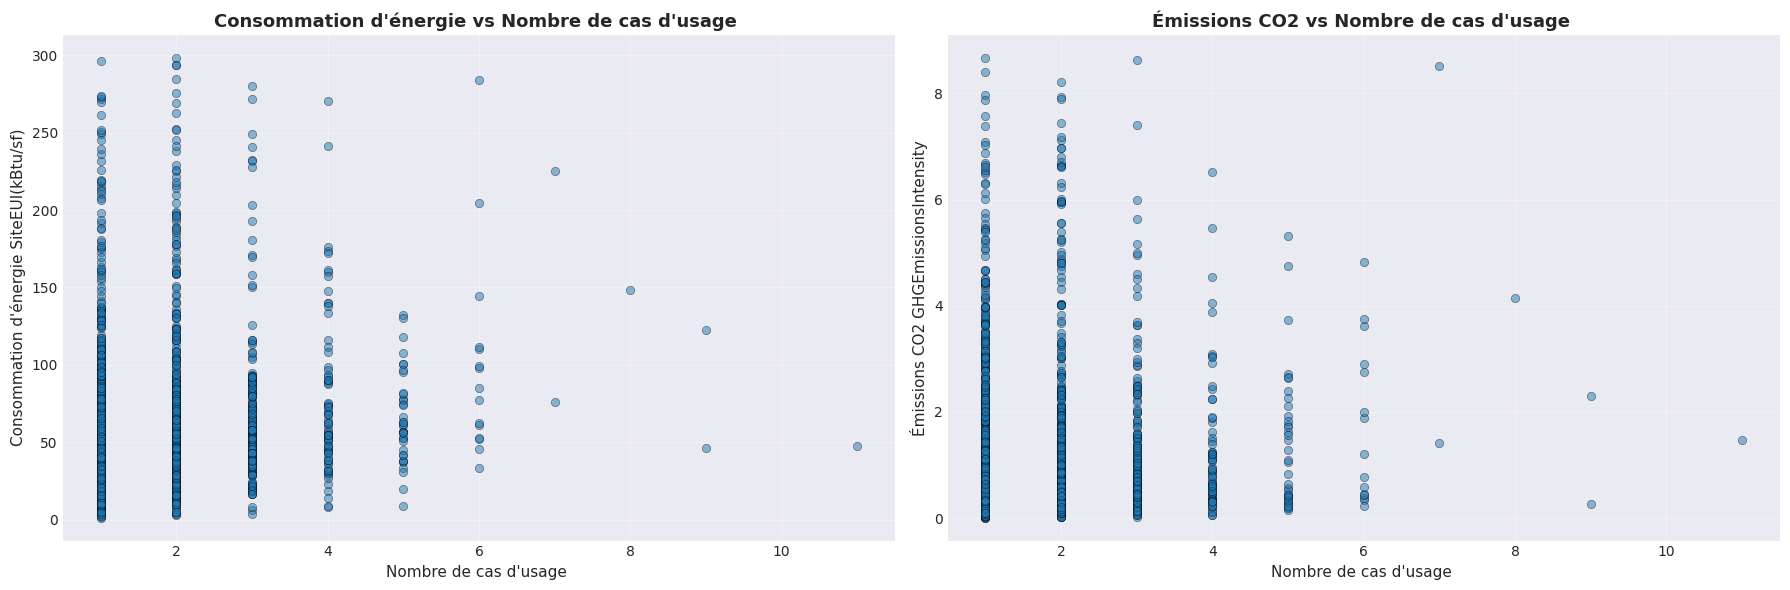

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

create_scatter(
    df,
    "num_property_uses",
    TARGET_ENERGY,
    "Consommation d'énergie vs Nombre de cas d'usage ",
    "Nombre de cas d'usage ",
    f"Consommation d'énergie {TARGET_ENERGY}",
    axes[0],
    False
)

create_scatter(
    df,
    "num_property_uses",
    TARGET_CO2,
    "Émissions CO2 vs Nombre de cas d'usage ",
    "Nombre de cas d'usage ",
    f"Émissions CO2 {TARGET_CO2}",
    axes[1],
    False
)
plt.tight_layout()
plt.show()

**Observations**

- La majorité des bâtiments ont un faible nombre de cas d’usage (1 à 3), avec une forte concentration des points dans cette zone.
- Lorsque le nombre de cas d’usage augmente, la consommation d’énergie et les émissions de CO2 restent très dispersées.
- Il n’y a pas de relation linéaire claire entre le nombre de cas d’usage et la consommation d’énergie.
- Les valeurs extrêmes de consommation et d’émissions apparaissent surtout pour un faible nombre de cas d’usage.
- Cela suggère que le nombre de cas d’usage seul n’est pas un bon prédicteur de la performance énergétique ou environnementale.

### 12.2. Quantitative vs Qualitative

**Objectif :** Comparer une variable numérique selon différentes catégories.


In [86]:
def create_boxplot(
    df: pd.DataFrame,
    ax: plt.Axes,
    x_col: Union[str, None] = None,
    y_col: Union[str, None] = None,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    rotate_x: int = 0,
    log_scale: bool = False
):
    sns.boxplot(
        data=df,
        x=x_col,
        y=y_col,
        ax=ax
    )

    if log_scale:
        ax.set_yscale("log")
        title = title + "(log scale)"
        ylabel = ylabel + "(log scale)"

    if rotate_x:
        ax.tick_params(axis='x', rotation=rotate_x)


    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


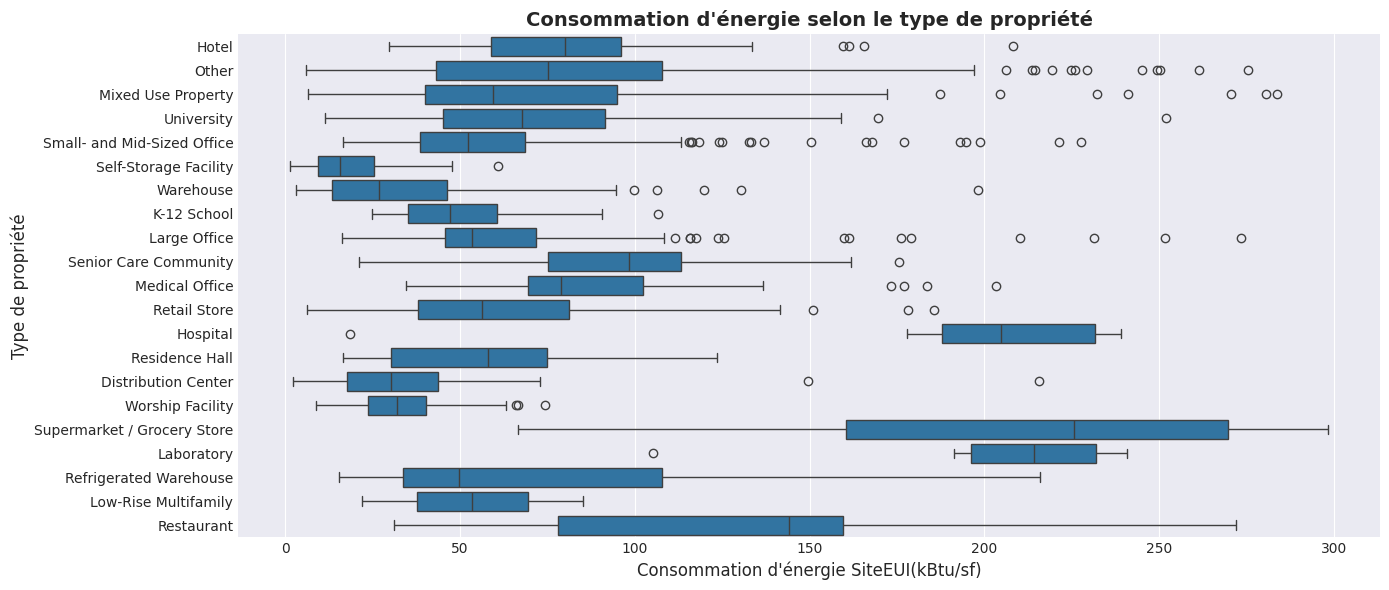

In [87]:
fig, ax = plt.subplots(figsize=(14, 6))
create_boxplot(
	df,
	ax,
	TARGET_ENERGY,
	'PrimaryPropertyType', 
	'Consommation d\'énergie selon le type de propriété',
	f'Consommation d\'énergie {TARGET_ENERGY}',
	'Type de propriété'
	)
plt.tight_layout()
plt.show()

**Observations**

- La consommation d’énergie varie fortement selon le type de propriété, avec des différences nettes entre les catégories.
- Les hôpitaux, restaurants et supermarchés présentent des consommations médianes élevées, ce qui reflète des usages intensifs en énergie.
- Les entrepôts, lieux de culte et installations de self-storage ont des consommations plus faibles et plus concentrées.
- Certaines catégories montrent une forte dispersion et de nombreux outliers, indiquant une grande hétérogénéité des bâtiments.
- Le type de propriété apparaît comme un facteur explicatif important de la consommation énergétique.


In [88]:
def create_violinplot(
    df: pd.DataFrame,
    ax: plt.Axes,
    x_col: Union[str, None] = None,
    y_col: Union[str, None] = None,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    rotate_x: int = 0,
    log_scale: bool = False,
    inner: str = "box"
):
    sns.violinplot(
        data=df,
        x=x_col,
        y=y_col,
        ax=ax,
        inner=inner
    )

    if log_scale:
        ax.set_yscale("log")
        title = title + " (log scale)"
        ylabel = ylabel + " (log scale)"

    if rotate_x:
        ax.tick_params(axis="x", rotation=rotate_x)

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


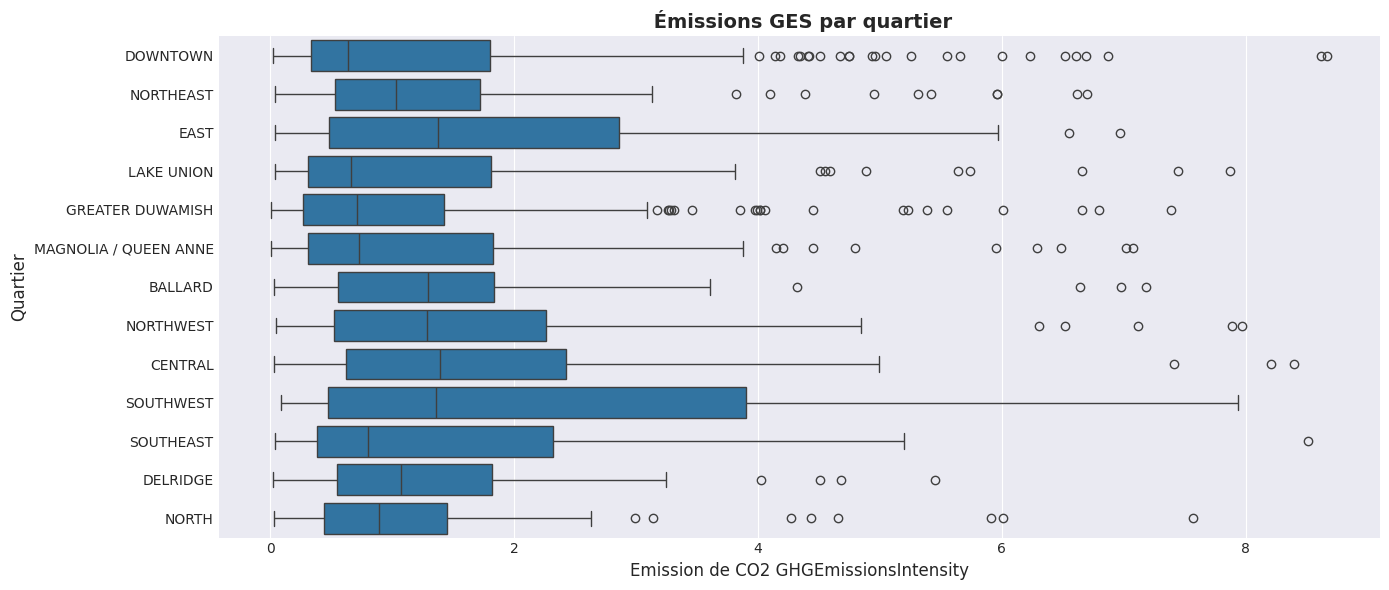

In [89]:
fig, ax = plt.subplots(figsize=(14, 6))
# create_boxplot
create_boxplot(
	df,
	ax,
	TARGET_CO2,
	'Neighborhood', 
	' Émissions GES par quartier',
	f'Emission de CO2 {TARGET_CO2}',
	'Quartier'
	)
plt.tight_layout()
plt.show()

**Observations**

- Les émissions de GES varient significativement selon les quartiers, avec des distributions différentes d’un quartier à l’autre.
- Les quartiers comme Downtown, Southwest et Central présentent des médianes plus élevées et une forte dispersion.
- Certains quartiers montrent de nombreux outliers, indiquant la présence de bâtiments très émetteurs.
- Les quartiers résidentiels ou moins denses tendent à avoir des émissions plus faibles en moyenne.
- Le quartier semble être un facteur géographique important influençant l’intensité des émissions de CO2.


### 3. Qualitative vs Qualitative

**Objectif :** Analyser la dépendance entre deux variables catégorielles.

In [90]:
def create_grouped_barplot(
    df: pd.DataFrame,
    ax: plt.Axes,
    x_col: str,
    hue_col: str,
    y_col: str | None = None,
    stat: str = "count",
    normalize: bool = False,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    legend_title: str = "",
    top_n_x: int | None = None,
    top_n_hue: int | None = None,
    rotate_x: int = 45
):
    df_copy = df.copy()

    if stat != "count":
        if y_col is None:
            raise ValueError("y_col must be provided when stat is not 'count'")

        agg_df = (
            df_copy
            .groupby([x_col, hue_col])[y_col]
            .agg(stat)
            .reset_index(name="value")
        )
    else:
        agg_df = (
            df_copy
            .groupby([x_col, hue_col])
            .size()
            .reset_index(name="value")
        )

    if normalize:
        agg_df["value"] = (
            agg_df
            .groupby(x_col)["value"]
            .transform(lambda x: x / x.sum())
        )

    sns.barplot(
        data=agg_df,
        x=x_col,
        y="value",
        hue=hue_col,
        ax=ax
    )

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis="x", rotation=rotate_x)
    ax.legend(title=legend_title)




def create_heatmap_contingency(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    xlabel: str,
    ylabel: str,
    top_n_x: int | None = None,
    top_n_y: int | None = None,
    normalize: bool = False,
    annot: bool = False,
    fmt: str = 'd'
):
    data = df.copy()

    if top_n_x is not None:
        top_x = data[x_col].value_counts().head(top_n_x).index
        data = data[data[x_col].isin(top_x)]

    if top_n_y is not None:
        top_y = data[y_col].value_counts().head(top_n_y).index
        data = data[data[y_col].isin(top_y)]

    contingency = pd.crosstab(
        data[y_col],
        data[x_col],
        normalize='index' if normalize else False
    )

    if annot and fmt is None:
        fmt = '.2f' if normalize else 'd'

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        contingency if not normalize else contingency * 100,
        cmap='Blues',
        annot=annot,
        fmt=fmt,
        linewidths=0.5
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


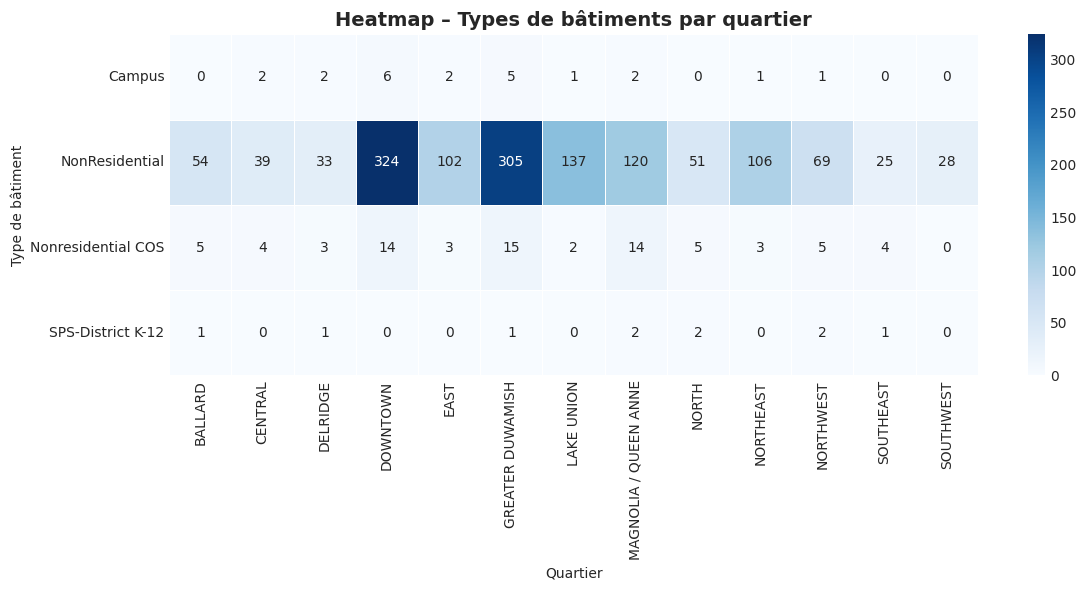

In [91]:
create_heatmap_contingency(
    df,
    x_col='Neighborhood',
    y_col='BuildingType',
    title="Heatmap – Types de bâtiments par quartier",
    xlabel="Quartier",
    ylabel="Type de bâtiment",
    normalize=False,  # True si tu veux des proportions
    annot=True
)

**Observations**

- Les bâtiments non résidentiels sont largement majoritaires dans tous les quartiers.
- Downtown et Greater Duwamish concentrent le plus grand nombre de bâtiments non résidentiels.
- Les bâtiments de type campus et scolaires (SPS-District K-12) sont très peu représentés et répartis de manière marginale.
- Certains quartiers montrent une diversité plus élevée de types de bâtiments que d’autres.
- La distribution des types de bâtiments dépend fortement du quartier, ce qui peut influencer les analyses énergétiques et environnementales.


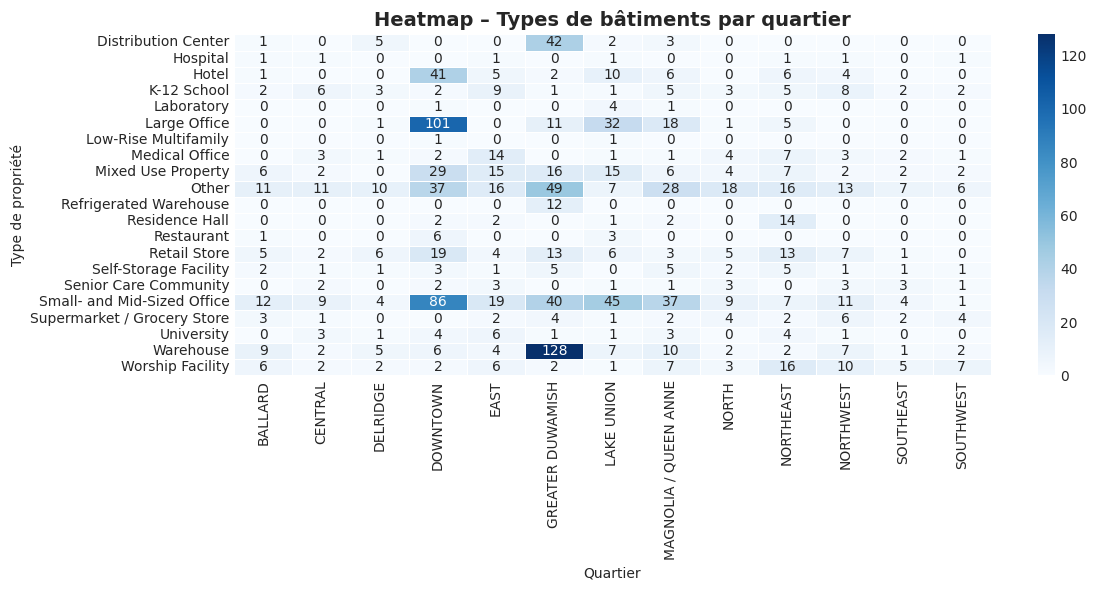

In [92]:
create_heatmap_contingency(
    df,
    x_col='Neighborhood',
    y_col='PrimaryPropertyType',
    title="Heatmap – Types de bâtiments par quartier",
    xlabel="Quartier",
    ylabel="Type de propriété",
    normalize=False,  # True si tu veux des proportions
    annot=True
)

**Observations**

- Certains types de propriétés sont fortement concentrés dans des quartiers spécifiques.
- Downtown concentre beaucoup de bureaux (Large Office, Small and Mid-Sized Office) et de propriétés mixtes.
- Greater Duwamish se distingue par une forte présence d’entrepôts et de centres de distribution.
- Les quartiers comme Lake Union et Magnolia / Queen Anne montrent une plus grande diversité de types de bâtiments.
- Cette répartition spatiale explique en partie les différences observées en consommation d’énergie et émissions de CO2 entre quartiers.


#### Type de bâtiment vs BuildingType

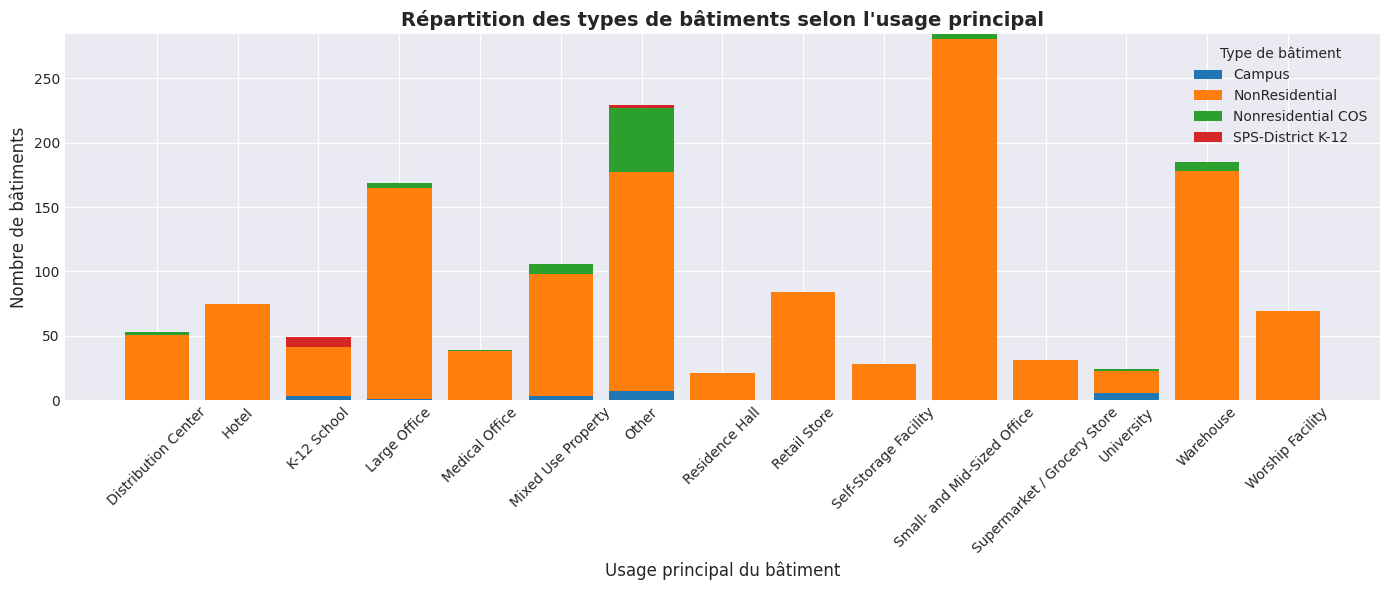

In [93]:
def create_stacked_barplot(
    df: pd.DataFrame,
    ax: plt.Axes,
    x_col: str,
    stack_col: str,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    legend_title: str = "",
    top_n_x: int | None = None,
    top_n_stack: int | None = None,
    rotate_x: int = 45,
    normalize: bool = False
):
    df_copy = df.copy()

    # Limiter la cardinalité
    if top_n_x is not None:
        top_x = df_copy[x_col].value_counts().head(top_n_x).index
        df_copy = df_copy[df_copy[x_col].isin(top_x)]

    if top_n_stack is not None:
        top_stack = df_copy[stack_col].value_counts().head(top_n_stack).index
        df_copy = df_copy[df_copy[stack_col].isin(top_stack)]

    # Table de contingence
    contingency = (
        df_copy
        .groupby([x_col, stack_col])
        .size()
        .unstack(fill_value=0)
    )

    # Normalisation optionnelle (proportions)
    if normalize:
        contingency = contingency.div(contingency.sum(axis=1), axis=0)

    # Barplot empilé
    bottom = pd.Series([0] * len(contingency), index=contingency.index)

    for category in contingency.columns:
        ax.bar(
            contingency.index,
            contingency[category],
            bottom=bottom,
            label=category
        )
        bottom += contingency[category]

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis="x", rotation=rotate_x)
    ax.legend(title=legend_title)


fig, ax = plt.subplots(figsize=(14, 6))

create_stacked_barplot(
    df=df,
    ax=ax,
    x_col="PrimaryPropertyType",
    stack_col="BuildingType",
    title="Répartition des types de bâtiments selon l'usage principal",
    xlabel="Usage principal du bâtiment",
    ylabel="Nombre de bâtiments",
    legend_title="Type de bâtiment",
    top_n_x=15,
    rotate_x=45
)


plt.tight_layout()
plt.show()

**Observations**

- Les bâtiments non résidentiels dominent largement tous les usages principaux représentés.
- Les usages comme Self-Storage Facility, Other et Warehouse regroupent un nombre élevé de bâtiments.
- Les bâtiments de type Campus et scolaires (SPS-District K-12) sont très minoritaires et concentrés sur quelques usages spécifiques.
- Certains usages, comme Mixed Use Property, présentent une plus grande diversité de types de bâtiments.
- La distribution par usage principal influence fortement la structure globale du parc immobilier analysé.


## Feature Engineering

Création de feature energiétiqye

In [94]:
# Feature: Présence de chauffage vapeur
df['has_steam'] = (df['SteamUse(kBtu)'] > 0).astype(int)
print(f"✅ has_steam : {df['has_steam'].sum()} bâtiments avec vapeur ({df['has_steam'].mean()*100:.1f}%)")

# Feature: Présence d'électricité
df['has_electricity'] = (df['Electricity(kBtu)'] > 0).astype(int)
print(f"✅ has_electricity : {df['has_electricity'].sum()} bâtiments avec électricité ({df['has_electricity'].mean()*100:.1f}%)")

# Feature: Présence de gaz naturel
df['has_natural_gas'] = (df['NaturalGas(kBtu)'] > 0).astype(int)
print(f"✅ has_natural_gas : {df['has_natural_gas'].sum()} bâtiments avec gaz ({df['has_natural_gas'].mean()*100:.1f}%)")


# Feature: Diversité des sources d'énergie (0 à 3)
df['energy_source_diversity'] = (
    df['has_steam'] + 
    df['has_electricity'] + 
    df['has_natural_gas']
)
distribution_column(df, 'energy_source_diversity')

# Feature: Indicateur multi-énergie (2+ sources)
df['is_multi_energy'] = (df['energy_source_diversity'] >= 2).astype(int)
print(f"\n✅ is_multi_energy : {df['is_multi_energy'].sum()} bâtiments multi-énergies ({df['is_multi_energy'].mean()*100:.1f}%)")


✅ has_steam : 106 bâtiments avec vapeur (7.1%)
✅ has_electricity : 1502 bâtiments avec électricité (100.0%)
✅ has_natural_gas : 1065 bâtiments avec gaz (70.9%)
📊 Distribution de la colonne energy_source_diversity
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
energy_source_diversity,,
2,1057,70.37
1,388,25.83
3,57,3.79



✅ is_multi_energy : 1114 bâtiments multi-énergies (74.2%)


On peut maintenant supprimer les colonne suivante qui ferais du dataleakage

In [95]:
df = remove_columns(df, ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 30)
   ➤ Colonnes demandées    : 5
✅ Suppression terminée
   ➤ Shape finale          : (1502, 25)
   ➤ Colonnes supprimées   : 5
   🧹 Liste supprimée       : ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)']


#### Temporalité

In [96]:
# Année de référence : année des relevés (2016)
REFERENCE_YEAR = 2016

# Feature: Âge du bâtiment (en années depuis 2016)
df['building_age'] = REFERENCE_YEAR - df['YearBuilt']
print(f"✅ building_age : min={df['building_age'].min()}, max={df['building_age'].max()}, moyenne={df['building_age'].mean():.1f} ans")

# Feature: Décennie de construction
df['decade_built'] = ((df['YearBuilt'] // 10) * 10).astype(str)
distribution_column(df, 'decade_built')

✅ building_age : min=1, max=116, moyenne=54.6 ans
📊 Distribution de la colonne decade_built
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
decade_built,,
1960,204,13.58
2000,174,11.58
1980,161,10.72
1920,152,10.12
1970,148,9.85
1950,145,9.65
1990,130,8.66
1900,116,7.72
1910,107,7.12


On peut maintenant supprimer la colonne `YearBuilt` qui sera forcement corélé avec les nouvelles features

In [97]:
df = remove_columns(df, ['YearBuilt'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 27)
   ➤ Colonnes demandées    : 1
✅ Suppression terminée
   ➤ Shape finale          : (1502, 26)
   ➤ Colonnes supprimées   : 1
   🧹 Liste supprimée       : ['YearBuilt']


#### Features de Surface et Densité
Ces features décrivent la configuration spatiale et l'utilisation de l'espace.

In [98]:
# Feature: Ratio de parking (surface parking / surface totale)
df['parking_ratio'] = df['PropertyGFAParking'] / df['PropertyGFATotal']
df['parking_ratio'] = df['parking_ratio'].fillna(0)  # Si division par 0
print(f"✅ parking_ratio : moyenne={df['parking_ratio'].mean():.3f}, max={df['parking_ratio'].max():.3f}")

# Feature: Présence de parking
df['has_parking'] = (df['PropertyGFAParking'] > 0).astype(int)
print(f"✅ has_parking : {df['has_parking'].sum()} bâtiments avec parking ({df['has_parking'].mean()*100:.1f}%)")


# Feature: Ratio bâtiment (surface bâtiment / surface totale)
df['building_ratio'] = df['PropertyGFABuilding(s)'] / df['PropertyGFATotal']
df['building_ratio'] = df['building_ratio'].fillna(1)  # Si pas de parking, ratio = 1
print(f"✅ building_ratio : moyenne={df['building_ratio'].mean():.3f}")

✅ parking_ratio : moyenne=0.065, max=0.798
✅ has_parking : 322 bâtiments avec parking (21.4%)
✅ building_ratio : moyenne=0.935


Feature : type d'usage 

In [99]:
# Feature: Ratio des 3 premiers types d'usage
df['largest_property_use_type_ratio'] = df['LargestPropertyUseTypeGFA'] / df['PropertyGFATotal']
print(f"✅ largest_property_use_type_ratio : moyenne={df['largest_property_use_type_ratio'].mean():.3f}, max={df['largest_property_use_type_ratio'].max():.3f}")
df['second_property_use_type_ratio'] = df['SecondLargestPropertyUseTypeGFA'] / df['PropertyGFATotal']
print(f"✅ second_property_use_type_ratio : moyenne={df['second_property_use_type_ratio'].mean():.3f}, max={df['second_property_use_type_ratio'].max():.3f}")
df['third_property_use_type_ratio'] = df['ThirdLargestPropertyUseTypeGFA'] / df['PropertyGFATotal']
print(f"✅ third_property_use_type_ratio : moyenne={df['third_property_use_type_ratio'].mean():.3f}, max={df['third_property_use_type_ratio'].max():.3f}")


# Feature: Indicateur multi-énergie (2+ sources)
df['is_mixed_use'] = (df['num_property_uses'] >= 2).astype(int)
print(f"\n✅ is_mixed_use : {df['is_mixed_use'].sum()} bâtiments multi-énergies ({df['is_multi_energy'].mean()*100:.1f}%)")


✅ largest_property_use_type_ratio : moyenne=0.857, max=6.427
✅ second_property_use_type_ratio : moyenne=0.128, max=1.159
✅ third_property_use_type_ratio : moyenne=0.022, max=0.490

✅ is_mixed_use : 814 bâtiments multi-énergies (74.2%)


On peut supprimer LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA qui seront fortement corrélé avec les nouvelles features

In [100]:
df = remove_columns(df, ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 33)
   ➤ Colonnes demandées    : 3
✅ Suppression terminée
   ➤ Shape finale          : (1502, 30)
   ➤ Colonnes supprimées   : 3
   🧹 Liste supprimée       : ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']


## Préparation des features pour la modélisation

### Suppression des features redondantes

Identifier et supprimer les features redondantes en utilisant une **matrice de corrélation de Pearson** afin de :
- limiter la **multicolinéarité**,  
- simplifier le modèle,  
- améliorer l’interprétabilité et la stabilité des coefficients.

### Principe  

La corrélation de **Pearson** mesure la **relation linéaire** entre deux variables numériques.  
Son coefficient, noté **r**, est compris entre **-1 et 1**.

### Types de corrélation et interprétation  

| Type de corrélation | Valeur du coefficient *r* | Interprétation |
|--------------------|---------------------------|----------------|
| Corrélation positive | r proche de **+1** | Lorsque la valeur d’une variable augmente, l’autre augmente également |
| Aucune corrélation | r proche de **0** | Pas de relation linéaire significative entre les variables |
| Corrélation négative | r proche de **-1** | Lorsque la valeur d’une variable augmente, l’autre diminue |

In [101]:
def heatmap_person(df):
    # 1. Calculer la matrice de corrélation
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    corr_matrix = df[numeric_cols].corr()

    # 2. Visualiser avec Seaborn
    plt.figure(figsize=(20, 16))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    sns.heatmap(corr_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                mask=mask,
                vmin=-1, vmax=1)

    plt.title('Matrice de corrélation de Pearson', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

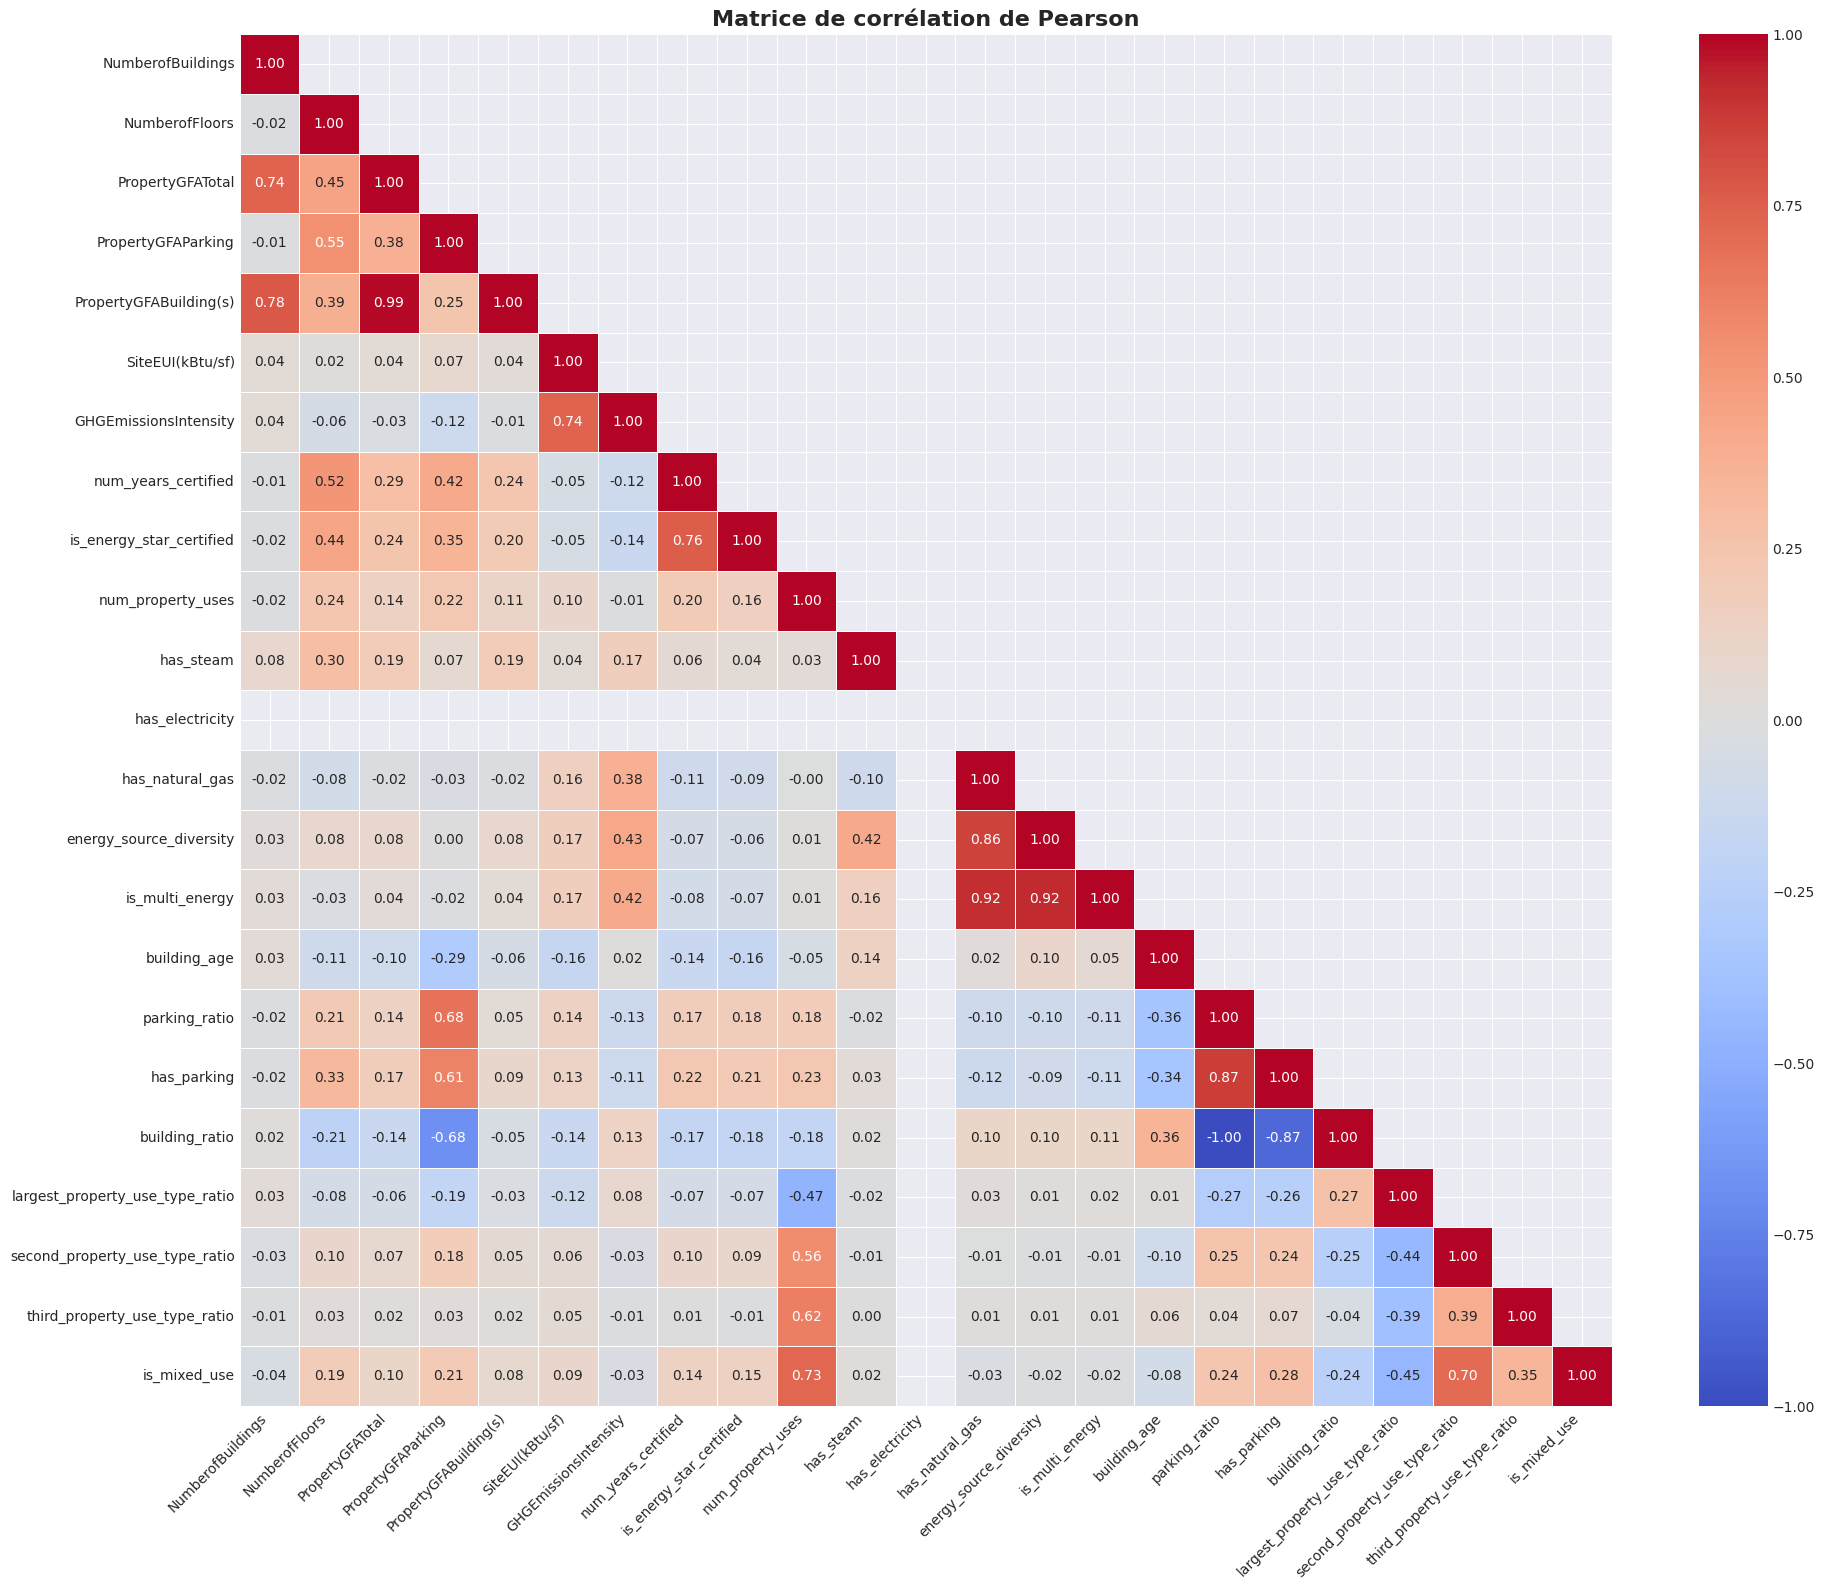

In [102]:
heatmap_person(df)

#### Analyse de Corrélation - Features Redondantes

**Features Hautement Corrélées (|r| ≥ 0.80)**

| Feature 1                      | Feature 2                      | Corrélation | Choix                                             |
|--------------------------------|--------------------------------|-------------|---------------------------------------------------|
| PropertyGFATotal               | PropertyGFABuilding(s)         | 0.99        | ❌ Supprimer PropertyGFATotal               |
| NumberofFloors                 | NumberofBuildings              | -0.02       | ✅ Garder les deux (pas de corrélation)           |
| has_natural_gas                | energy_source_diversity        | 0.86        | ❌ Supprimer energy_source_diversity              |
| is_multi_energy                | energy_source_diversity        | 0.92        | ❌ Supprimer is_multi_energy                      |
| is_multi_energy                | has_natural_gas                | 0.92        | ❌ Supprimer is_multi_energy                      |
| has_parking                    | parking_ratio                  | 0.87        | ❌ Supprimer has_parking (dérivée)                |
| building_ratio                 | parking_ratio                  | -1.00       | ❌ Supprimer building_ratio                       |
| building_ratio                 | has_parking                    | -0.87       | ❌ Supprimer building_ratio                       |

**Features Modérément Corrélées (0.70 ≤ |r| < 0.80)**

| Feature 1                      | Feature 2                      | Corrélation | Choix                                             |
|--------------------------------|--------------------------------|-------------|---------------------------------------------------|
| SiteEUI(kBtu/sf)               | GHGEmissionsIntensity          | 0.74        | ✅ Garder les deux (relation causale importante)  |
| num_years_certified            | is_energy_star_certified       | 0.76        | ❌ Supprimer num_years_certified (dérivée)        |
| is_mixed_use                   | num_property_uses              | 0.73        | ❌ Supprimer is_mixed_use (dérivée)               |
| PropertyGFATotal               | NumberofBuildings              | 0.74        | ✅ Garder les deux (relation causale légitime)    |

**Résumé des Suppressions Recommandées**

| Feature à Supprimer            | Raison                                           | Feature à Conserver          |
|--------------------------------|--------------------------------------------------|------------------------------|
| PropertyGFATotal         | Très forte corrélation (r=0.99)                  | PropertyGFABuilding(s)             |
| energy_source_diversity        | Forte corrélation avec has_natural_gas (r=0.86)  | has_natural_gas              |
| is_multi_energy                | Très forte corrélation (r=0.92)                  | has_natural_gas              |
| has_parking                    | Dérivée de parking_ratio (r=0.87)                | parking_ratio                |
| building_ratio                 | Corrélation parfaite inverse (r=-1.00)           | parking_ratio                |
| num_years_certified            | Dérivée de is_energy_star_certified (r=0.76)     | is_energy_star_certified     |
| is_mixed_use                   | Dérivée de num_property_uses (r=0.73)            | num_property_uses            |

**Total : 7 features redondantes à supprimer**

**Notes Importantes**

1. **PropertyGFAParking** : Corrélation modérée avec PropertyGFATotal (0.38) et PropertyGFABuilding(s) (0.25) - à conserver
2. **GHGEmissionsIntensity** : Corrélation faible avec PropertyGFAParking (-0.12) - variables indépendantes
3. **has_steam** : Corrélations faibles avec autres features - information unique à conserver
4. **building_age** : Corrélations négatives modérées mais information temporelle importante

In [103]:
columns_to_drop = [
    'PropertyGFATotal',
    'energy_source_diversity',
    'is_multi_energy',
    'has_parking',
    'building_ratio',
    'num_years_certified',
    'is_mixed_use'
]

df = remove_columns(df, columns_to_drop)

📦 Suppression de colonnes
   ➤ Shape initiale        : (1502, 30)
   ➤ Colonnes demandées    : 7
✅ Suppression terminée
   ➤ Shape finale          : (1502, 23)
   ➤ Colonnes supprimées   : 7
   🧹 Liste supprimée       : ['PropertyGFATotal', 'energy_source_diversity', 'is_multi_energy', 'has_parking', 'building_ratio', 'num_years_certified', 'is_mixed_use']


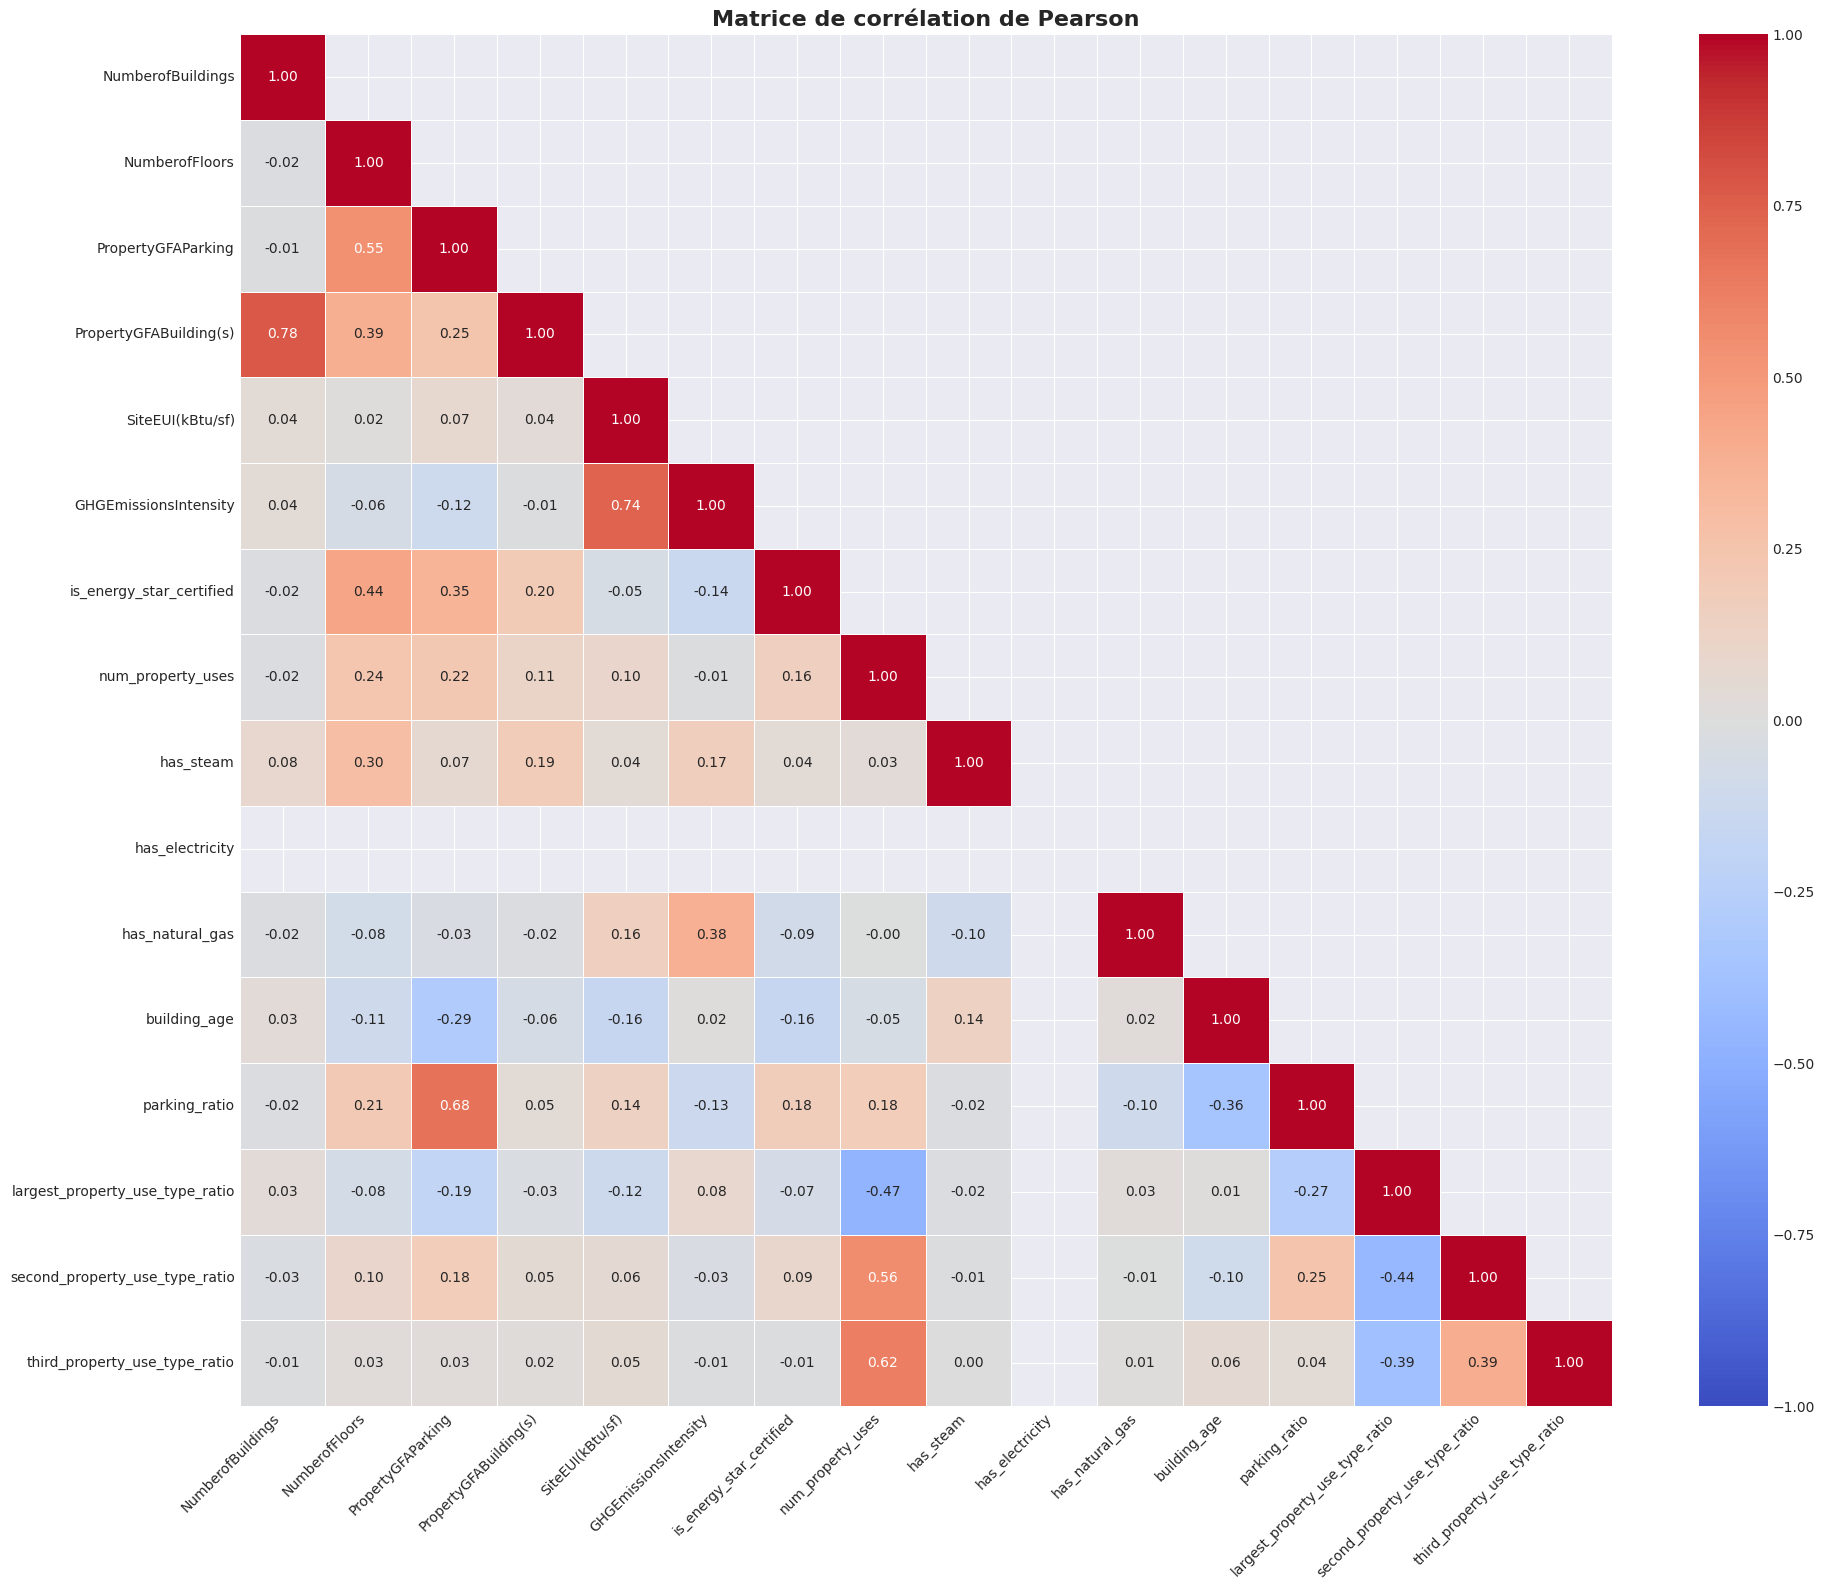

In [104]:
heatmap_person(df)

In [105]:
df.to_csv('data/data_clean.csv', index=False)